# Cascade Identification - Exploratory Data Analysis

**Problem**: Given event X, predict what types of secondary events occur (multilabel).

This notebook explores:
1. Understanding the NOAA Storm Events data structure
2. Identifying causal cascade patterns
3. Creating multilabel targets for modeling

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100

print("Ready!")

Ready!


In [2]:
%cd 'c:\\Users\\preet\\github_repos\\cascading-disaster-prediction\\notebooks'

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "'c:\\\\Users\\\\preet\\\\github_repos\\\\cascading-disaster-prediction\\\\notebooks'"
c:\Users\preet\github_repos\cascading-disaster-prediction\notebooks


In [3]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))
import src.data_loader

In [4]:
# Debug: reload `src.data_loader` and show status
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

import importlib, time, pathlib
import src.data_loader as dl

importlib.reload(dl)

<module 'src.data_loader' from 'C:\\Users\\preet\\github_repos\\cascading-disaster-prediction\\src\\data_loader.py'>

---
# Part 1: Understanding the Raw Data

Before cascade identification, let's explore what the data looks like.

## 1.1 DataFrame Overview

In [5]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

gauth = GoogleAuth()

# This tells PyDrive to look one level up (..) for the secret file
gauth.LoadClientConfigFile("../client_secrets.json") 

# This will open your browser for the token
gauth.LocalWebserverAuth() 

drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=393324286057-1ss6c79d2b3p4ru67cu69kqe97dslmr7.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Authentication successful.


In [6]:
import io
import pandas as pd

from src.data_loader import read_csv_from_gdrive

DETAILS_FOLDER_ID = '10AL1ePzqiPGgzTCL9X8ruOdVMjrEBufw'
FATALITIES_FOLDER_ID = "1QGIxDfK2ab7H_FIv-himHIMXn-RGAT-5"
LOCATIONS_FOLDER_ID = "10syO2OS4QzQLOQY7DkQQvgDdXbMYbucL"
details_df = read_csv_from_gdrive(drive, DETAILS_FOLDER_ID, "Details")
fatalities_df = read_csv_from_gdrive(drive, FATALITIES_FOLDER_ID, "Fatalities")
locations_df = read_csv_from_gdrive(drive, LOCATIONS_FOLDER_ID, "Locations")

Fetching StormEvents_details-ftp_v1.0_d2022_c20250721.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2023_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2024_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2025_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2021_c20250520.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2020_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2019_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2018_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2017_c20260116.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2015_c20251118.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2016_c20250818.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2014_c20250520.csv from Details...
Fetching StormEvents_details-ftp_v1.0_d2012_c20250520.csv from Details...
Fetching StormEvents_details-ftp_v1.0_

In [10]:
details_df.head()
fatalities_df.head()
locations_df.head()

,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,202506,201403,1254841,4,0.39,SE,HAVASUPAI,36.2261,-112.6948,3613566.0,11241688.0
1,202506,201403,1254841,5,0.58,ESE,HAVASUPAI,36.2263,-112.6906,3613578.0,11241436.0
2,202506,201461,1256630,1,0.49,S,LEEDS,39.0429,-94.5001,392574.0,9430006.0
3,202506,201461,1256630,2,0.70,E,LEEDS,39.0496,-94.4870,392976.0,9429220.0
4,202506,201461,1256632,1,1.61,SW,EAST INDEPENDENCE,39.0824,-94.3896,394944.0,9423376.0


In [22]:
# List of your DataFrames and their names for the labels
dfs = {
    "Details": details_df,
    "Locations": locations_df,
    "Fatalities": fatalities_df
}

for name, df in dfs.items():
    print(f"{'='*30}")
    print(f"DATASET: {name}")
    print(f"{'='*30}")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
    print(f"\nColumns ({len(df.columns)}):")
    print(df.columns.tolist())
    print("\n")

DATASET: Details
Shape: (2005532, 51)
Memory usage: 3915.4 MB

Columns (51):
['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE']


DATASET: Locations
Shape: (1770317, 11)
Memory usage: 307.2 MB

Columns (11):
['YEARMONTH', 'EPISODE_ID', 'EVENT_ID', 'LOCATION_INDEX', 'RANGE', 'AZIMUTH', 'LO

In [ ]:
from src.data_loader import join_storm_data, parse_noaa_datetime

# 1. Join the datasets
print("Joining DataFrames...")
final_df = join_storm_data(details_df, fatalities_df, locations_df)

# 2. Fix DateTime formats
# We create new columns to preserve the original strings just in case
print("Parsing datetime columns (this may take a minute)...")
final_df['BEGIN_DATETIME'] = final_df['BEGIN_DATE_TIME'].apply(parse_noaa_datetime)
final_df['END_DATETIME'] = final_df['END_DATE_TIME'].apply(parse_noaa_datetime)

# 3. Clean up Damage Values (using your utility function)
from src.data_loader import parse_damage_value
print("Normalizing damage values to USD...")
final_df['DAMAGE_PROPERTY_USD'] = final_df['DAMAGE_PROPERTY'].apply(parse_damage_value)
final_df['DAMAGE_CROPS_USD'] = final_df['DAMAGE_CROPS'].apply(parse_damage_value)
final_df['TOTAL_DAMAGE_USD'] = final_df['DAMAGE_PROPERTY_USD'] + final_df['DAMAGE_CROPS_USD']

print(f"Final Dataset Ready: {final_df.shape[0]:,} events with {final_df.shape[1]} columns.")
display(final_df[['BEGIN_DATETIME', 'EVENT_TYPE', 'STATE', 'FATALITY_COUNT', 'DAMAGE_PROPERTY_USD']].head())

Joining DataFrames...
Parsing datetime columns (this may take a minute)...
Normalizing damage values to USD...
Final Dataset Ready: 2,005,532 events with 61 columns.


,BEGIN_DATETIME,EVENT_TYPE,STATE,FATALITY_COUNT,DAMAGE_PROPERTY_USD
0,2022-02-20 21:18:00,High Wind,NEVADA,0,0.0
1,2022-02-21 08:00:00,Heavy Snow,NEVADA,0,0.0
2,2022-02-22 02:00:00,Heavy Snow,NEVADA,0,0.0
3,2022-02-18 16:09:00,Waterspout,ATLANTIC SOUTH,0,0.0
4,2022-02-02 00:00:00,Heavy Rain,AMERICAN SAMOA,0,50000.0


In [24]:
# Data types and missing values
info_df = pd.DataFrame({
    'dtype': final_df.dtypes,
    'non_null': final_df.count(),
    'null_pct': (final_df.isnull().sum() / len(final_df) * 100).round(1)
})
info_df[info_df['null_pct'] > 0].sort_values('null_pct', ascending=False).head(20)

,dtype,non_null,null_pct
CATEGORY,float64,560,100.0
TOR_OTHER_CZ_FIPS,float64,3737,99.8
TOR_OTHER_CZ_STATE,object,3737,99.8
TOR_OTHER_WFO,object,3737,99.8
TOR_OTHER_CZ_NAME,object,3737,99.8
FATALITY_TYPES,str,14717,99.3
TOR_F_SCALE,str,78319,96.1
FLOOD_CAUSE,object,125671,93.7
TOR_WIDTH,float64,274991,86.3
TOR_LENGTH,float64,274991,86.3


## 1.2 Key Columns for Cascade Analysis

In [38]:
key_cols = [
    # 1. Primary Identifiers
    'EVENT_ID', 'EPISODE_ID', 'EVENT_TYPE', 'YEAR', 'MONTH_NAME',
    
    # 2. Temporal Logic (Cascade Sequencing)
    'BEGIN_DATETIME', 'END_DATETIME', 'CZ_TIMEZONE',
    
    # 3. Spatial Logic (Cascade Matching)
    'STATE', 'STATE_FIPS', 'CZ_NAME', 'CZ_FIPS', 'WFO',
    'LATITUDE', 'LONGITUDE',  # Joined from locations
    'BEGIN_LAT', 'BEGIN_LON', # Original records
    'BEGIN_LOCATION', 'END_LOCATION',
    
    # 4. Severity & Mechanisms (Triggers)
    'MAGNITUDE', 'MAGNITUDE_TYPE', 'TOR_F_SCALE', 
    'FLOOD_CAUSE', 'CATEGORY',
    
    # 5. Impact & Loss (Cascade Consequences)
    'FATALITY_COUNT', 'FATALITY_TYPES',
    'INJURIES_DIRECT', 'INJURIES_INDIRECT',
    'DEATHS_DIRECT', 'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY_USD', 'DAMAGE_CROPS_USD', 'TOTAL_DAMAGE_USD',
    
    
    # 6. Qualitative Context (NLP/Validation)
    'EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'SOURCE'
]

# Create the subset
research_df = final_df[key_cols]
print(f"Research DataFrame ready with {research_df.shape[1]} prioritized columns.")

Research DataFrame ready with 36 prioritized columns.


In [40]:
# Grouping columns by their physical/impact meaning
impact_cols = [
    'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 
    'FATALITY_COUNT', 'INJURIES_DIRECT', 'DEATHS_DIRECT',
    'DAMAGE_PROPERTY_USD', 'DAMAGE_CROPS_USD', 'TOTAL_DAMAGE_USD'
]

# Spatial columns for distance-based analysis
coords_cols = ['LATITUDE', 'LONGITUDE', 'BEGIN_LAT', 'BEGIN_LON']

# 1. Run descriptive stats on impact metrics
print("=== Impact & Severity Summary ===")
display(final_df[impact_cols].describe().round(2))

# 2. Check for missing values in geographic coordinates
print("\n=== Geographic Data Health ===")
print(final_df[coords_cols].isnull().sum())

=== Impact & Severity Summary ===


,MAGNITUDE,TOR_LENGTH,TOR_WIDTH,FATALITY_COUNT,INJURIES_DIRECT,DEATHS_DIRECT,DAMAGE_PROPERTY_USD,DAMAGE_CROPS_USD,TOTAL_DAMAGE_USD
count,1147404.00,274991.00,274991.00,2005532.00,2005532.00,2005532.00,2.005532e+06,2.005532e+06,2.005532e+06
mean,28.39,0.98,38.58,0.01,0.08,0.01,3.001306e+05,3.526322e+04,3.353938e+05
std,34.50,8.00,141.65,0.57,3.59,0.59,2.966882e+07,2.448600e+06,2.985550e+07
min,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00
50%,37.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00
75%,52.00,0.10,20.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00
max,22000.00,2315.00,4576.00,638.00,1700.00,638.00,1.790000e+10,1.500000e+09,1.790000e+10



=== Geographic Data Health ===
LATITUDE     979447
LONGITUDE    979447
BEGIN_LAT    772763
BEGIN_LON    772771
dtype: int64


## 1.3 Event Types

In [34]:
print(f"Unique event types: {final_df['EVENT_TYPE'].nunique()}")
print("\nAll event types:")
print(sorted(final_df['EVENT_TYPE'].unique()))

Unique event types: 57

All event types:
['Astronomical Low Tide', 'Avalanche', 'Blizzard', 'Coastal Flood', 'Cold/Wind Chill', 'Debris Flow', 'Dense Fog', 'Dense Smoke', 'Drought', 'Dust Devil', 'Dust Storm', 'Excessive Heat', 'Extreme Cold/Wind Chill', 'Flash Flood', 'Flood', 'Freezing Fog', 'Frost/Freeze', 'Funnel Cloud', 'Hail', 'Heat', 'Heavy Rain', 'Heavy Snow', 'High Surf', 'High Wind', 'Hurricane', 'Hurricane (Typhoon)', 'Ice Storm', 'Lake-Effect Snow', 'Lakeshore Flood', 'Lightning', 'Marine Dense Fog', 'Marine Hail', 'Marine High Wind', 'Marine Hurricane/Typhoon', 'Marine Lightning', 'Marine Strong Wind', 'Marine Thunderstorm Wind', 'Marine Tropical Depression', 'Marine Tropical Storm', 'Northern Lights', 'Rip Current', 'Seiche', 'Sleet', 'Sneakerwave', 'Storm Surge/Tide', 'Strong Wind', 'Thunderstorm Wind', 'Tornado', 'Tropical Depression', 'Tropical Storm', 'Tsunami', 'Volcanic Ash', 'Volcanic Ashfall', 'Waterspout', 'Wildfire', 'Winter Storm', 'Winter Weather']


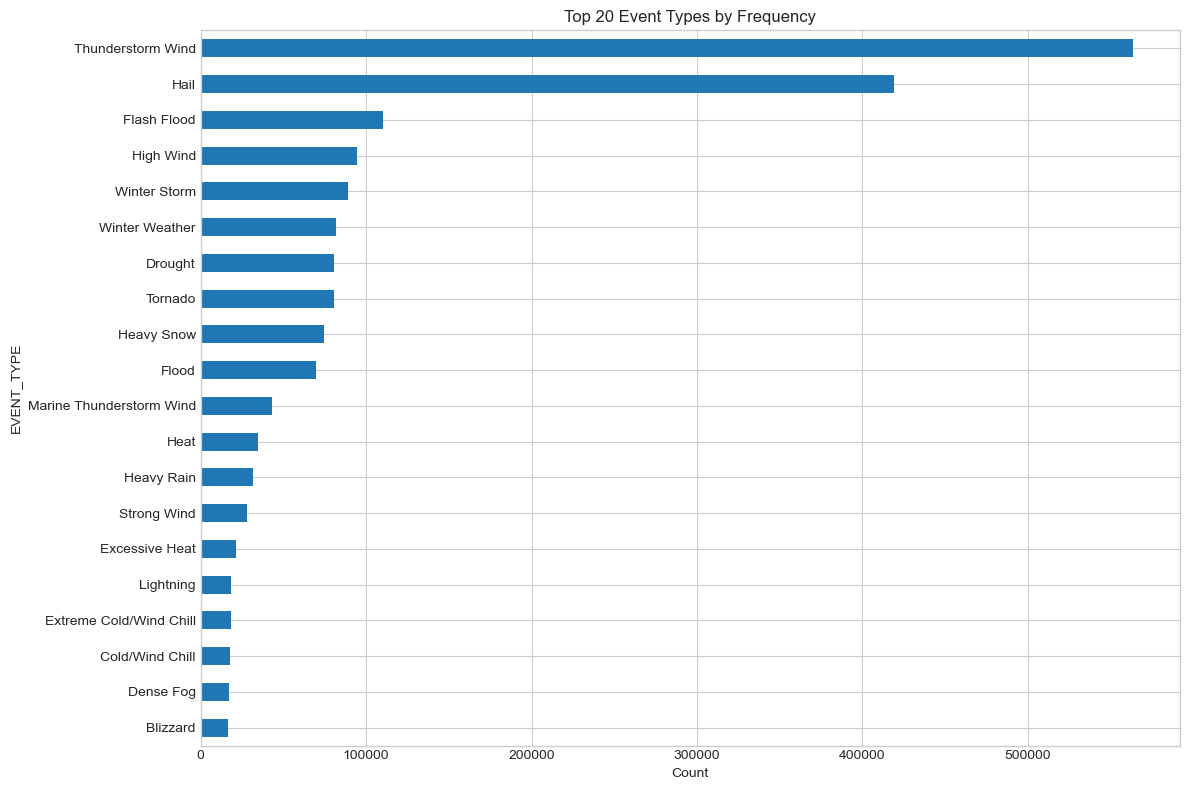

In [35]:
# Top event types by count
event_counts = final_df['EVENT_TYPE'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
event_counts.head(20).plot(kind='barh', ax=ax)
ax.set_xlabel('Count')
ax.set_title('Top 20 Event Types by Frequency')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [41]:
# Event types by total damage
from src.data_loader import get_event_type_summary

event_summary = get_event_type_summary(final_df)
event_summary.head(15)

,count,INJURIES_DIRECT,DEATHS_DIRECT,TOTAL_DAMAGE_USD
EVENT_TYPE,,,,
Thunderstorm Wind,563711,11757,1162,1.679154e+10
Hail,418854,1636,15,3.713682e+10
Flash Flood,110171,6521,2128,1.040195e+11
High Wind,94492,1598,390,1.656789e+10
Winter Storm,89291,1493,253,3.213209e+09
Winter Weather,81652,2403,192,1.310607e+08
Drought,80633,354,0,3.127911e+10
Tornado,80286,99283,6349,7.771837e+10
Heavy Snow,74734,741,133,1.139344e+09


## 1.4 Episode Structure

NOAA groups related events into **episodes**. This is key for cascade identification.

In [42]:
episode_sizes = final_df.groupby('EPISODE_ID').size()

print(f"Total episodes: {len(episode_sizes):,}")
print(f"\nEvents per episode:")
print(episode_sizes.describe())
print(f"\nEpisodes with 2+ events: {(episode_sizes >= 2).sum():,} ({(episode_sizes >= 2).mean()*100:.1f}%)")
print(f"Largest episode: {episode_sizes.max()} events")

Total episodes: 393,316

Events per episode:
count    393316.000000
mean          4.508555
std           8.186061
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         412.000000
dtype: float64

Episodes with 2+ events: 187,521 (47.7%)
Largest episode: 412 events


In [45]:
# Sample a multi-event episode
multi_episodes = episode_sizes[episode_sizes >= 3].index[:3]

for ep_id in multi_episodes:
    episode = final_df[final_df['EPISODE_ID'] == ep_id][['EVENT_TYPE', 'STATE', 'BEGIN_DATETIME', 'TOTAL_DAMAGE_USD']]
    print(f"\n--- Episode {ep_id} ({len(episode)} events) ---")
    display(episode.sort_values('BEGIN_DATETIME'))


--- Episode 1.0 (4 events) ---


,EVENT_TYPE,STATE,BEGIN_DATETIME,TOTAL_DAMAGE_USD
1323741,Winter Weather,COLORADO,2006-10-09 15:00:00,0.0
1323742,Winter Weather,COLORADO,2006-10-09 15:00:00,0.0
1323743,Winter Weather,COLORADO,2006-10-09 15:00:00,0.0
1324325,Winter Weather,COLORADO,2006-10-09 15:00:00,0.0



--- Episode 7.0 (4 events) ---


,EVENT_TYPE,STATE,BEGIN_DATETIME,TOTAL_DAMAGE_USD
1324237,High Wind,NEW MEXICO,2006-10-26 13:53:00,0.0
1324238,High Wind,NEW MEXICO,2006-10-26 14:00:00,3000.0
1324235,Heavy Snow,NEW MEXICO,2006-10-26 15:30:00,0.0
1324236,Heavy Snow,NEW MEXICO,2006-10-26 15:30:00,0.0



--- Episode 10.0 (5 events) ---


,EVENT_TYPE,STATE,BEGIN_DATETIME,TOTAL_DAMAGE_USD
1323914,Flash Flood,TEXAS,2006-10-15 03:00:00,50000.0
1323971,Thunderstorm Wind,TEXAS,2006-10-15 11:17:00,0.0
1326198,Flash Flood,TEXAS,2006-10-15 11:20:00,40000.0
1324242,Flash Flood,TEXAS,2006-10-15 18:35:00,0.0
1326199,Flash Flood,TEXAS,2006-10-15 20:05:00,0.0


## 1.5 Fatalities Analysis

Events with fatalities: 14,717
Total fatalities: 25,191


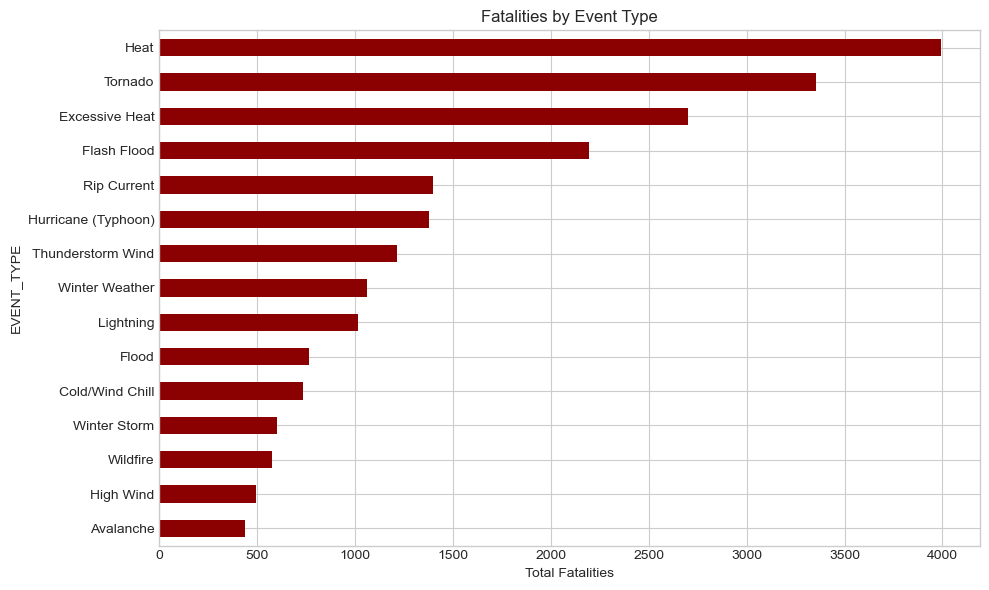

In [46]:
print(f"Events with fatalities: {(final_df['FATALITY_COUNT'] > 0).sum():,}")
print(f"Total fatalities: {final_df['FATALITY_COUNT'].sum():,}")

# Fatalities by event type
fatality_by_type = final_df.groupby('EVENT_TYPE')['FATALITY_COUNT'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
fatality_by_type.head(15).plot(kind='barh', ax=ax, color='darkred')
ax.set_xlabel('Total Fatalities')
ax.set_title('Fatalities by Event Type')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 1.6 Temporal Patterns

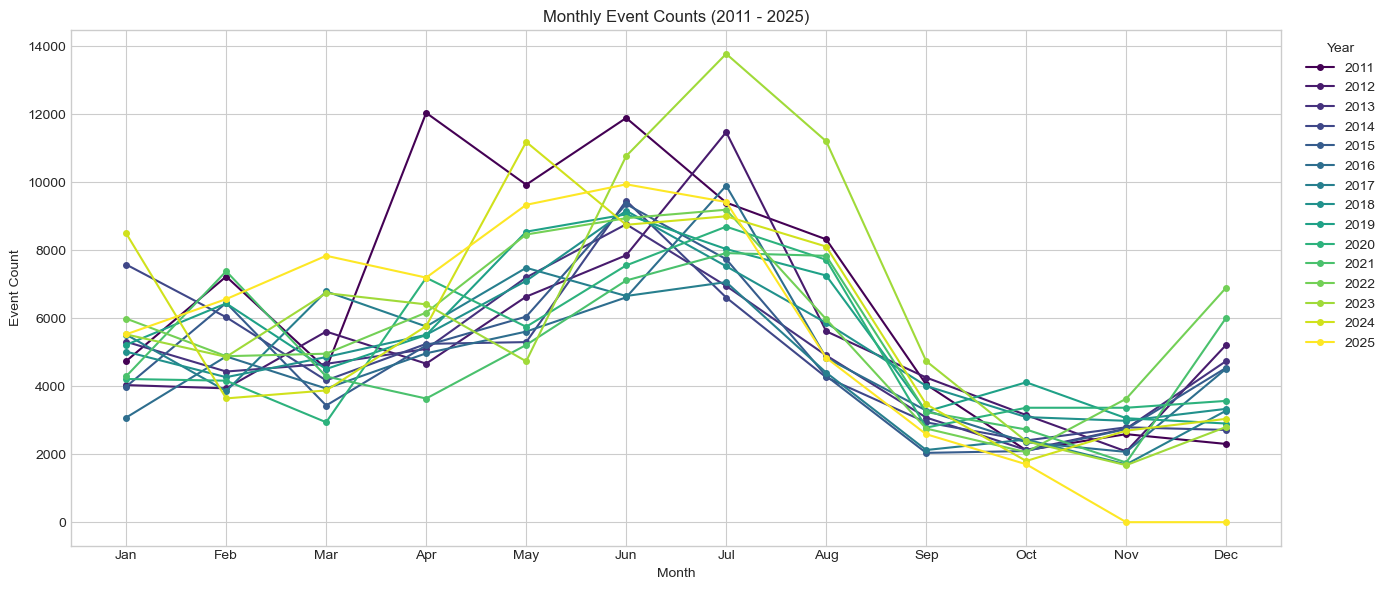

In [49]:
# 1. Create time features
final_df['month'] = final_df['BEGIN_DATETIME'].dt.month
final_df['year'] = final_df['BEGIN_DATETIME'].dt.year

# 2. Filter for years after 2010 (and before 2026 to avoid those future-date artifacts)
plot_df = final_df[(final_df['year'] > 2010) & (final_df['year'] < 2026)]
monthly = plot_df.groupby(['year', 'month']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))
monthly.T.plot(kind='line', ax=ax, marker='o', markersize=4, colormap='viridis')

ax.set_xlabel('Month')
ax.set_ylabel('Event Count')
ax.set_title('Monthly Event Counts (2011 - 2025)')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.legend(title='Year', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

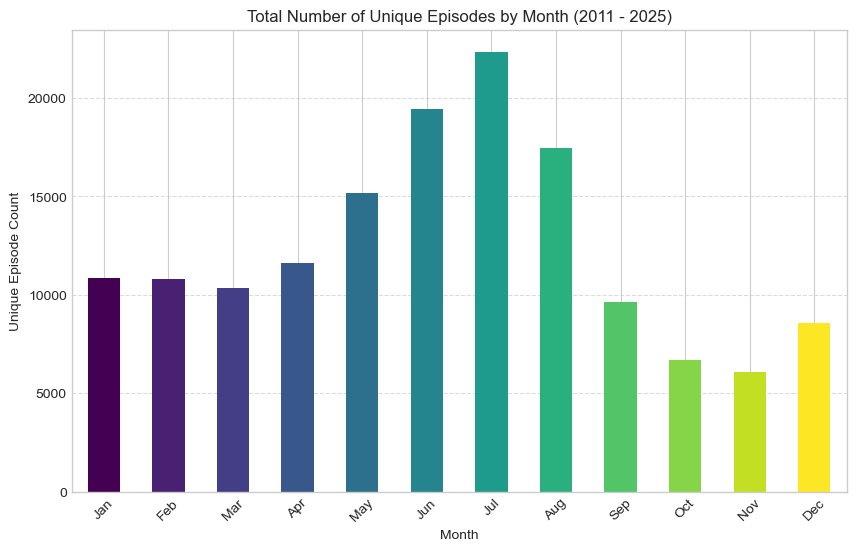

The month with the maximum number of episodes is: Jul


In [52]:
# Aggregate unique episodes by month across all years (>2010)
monthly_episodes = plot_df.groupby('month')['EPISODE_ID'].nunique()

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 12))
monthly_episodes.plot(kind='bar', color=colors, ax=plt.gca())

plt.title('Total Number of Unique Episodes by Month (2011 - 2025)')
plt.xlabel('Month')
plt.ylabel('Unique Episode Count')
plt.xticks(range(0, 12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print the maximum month
max_month_idx = monthly_episodes.idxmax()
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
print(f"The month with the maximum number of episodes is: {month_names[max_month_idx-1]}")

## 1.7 Geographic Distribution

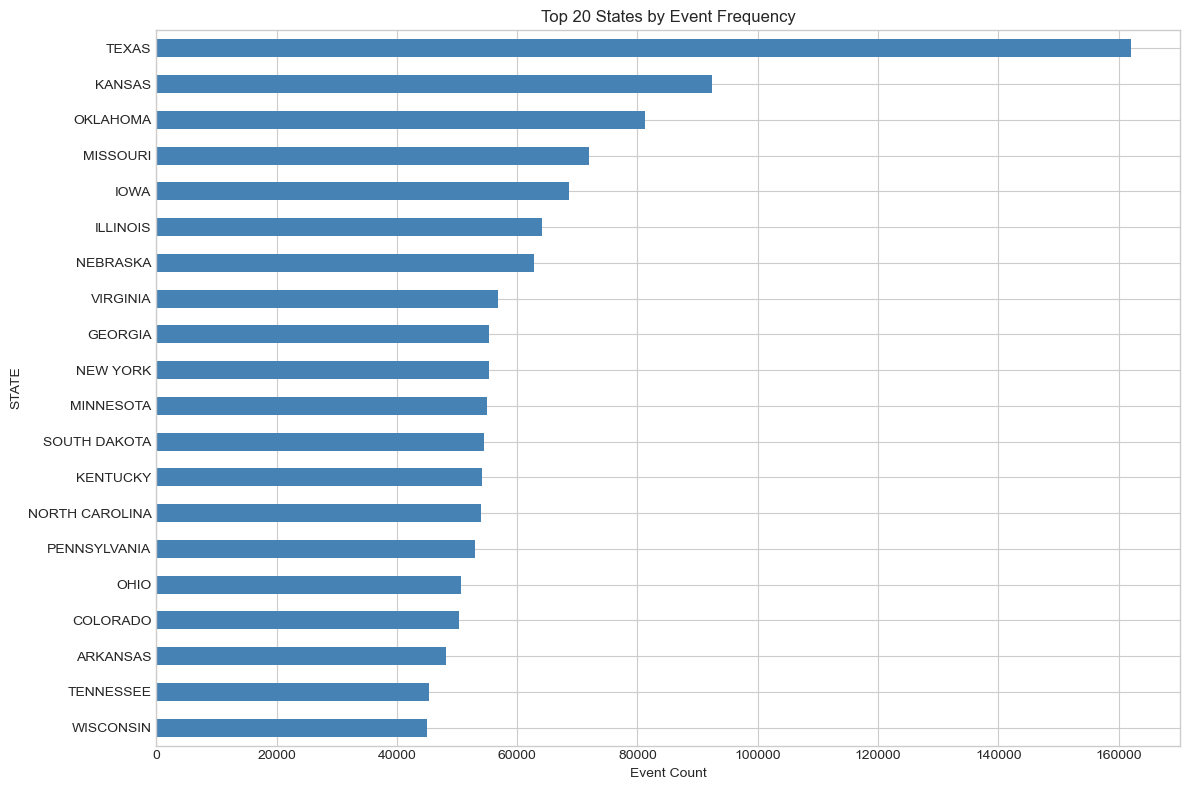

In [53]:
state_counts = final_df['STATE'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
state_counts.head(20).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Event Count')
ax.set_title('Top 20 States by Event Frequency')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
# Part 2: Cascade Identification

Now we use our cascade definition to find causal cascade pairs.

In [200]:
from src.cascade_definition import get_conservative_config, get_exploratory_config, CAUSAL_CASCADE_PATTERNS, print_cascade_patterns
from src.cascade_identification import identify_cascades, cascades_to_dataframe

# Show documented causal patterns
print_cascade_patterns()

DOCUMENTED CAUSAL CASCADE PATTERNS

Avalanche →
    Flash Flood
    Debris Flow
    Flood

Blizzard →
    Avalanche
    Frost/Freeze
    Extreme Cold/Wind Chill
    Heavy Snow
    Lake-Effect Snow

Cold/Wind Chill →
    Frost/Freeze
    Extreme Cold/Wind Chill

Debris Flow →
    Flood
    Flash Flood

Dense Fog →
    Freezing Fog

Dense Smoke →
    Wildfire

Drought →
    Wildfire
    Heat
    Excessive Heat
    Dust Storm
    Dense Smoke

Dust Devil →
    Dust Storm

Dust Storm →
    Dense Smoke
    Dense Fog

Earthquake →
    Landslide
    Tsunami
    Debris Flow
    Flash Flood
    Avalanche

Excessive Heat →
    Drought
    Wildfire
    Heat

Extreme Cold/Wind Chill →
    Frost/Freeze
    Avalanche

Flash Flood →
    Debris Flow
    Landslide
    Flood

Flood →
    Debris Flow
    Landslide
    Lakeshore Flood

Freezing Fog →
    Ice Storm
    Frost/Freeze

Frost/Freeze →
    Cold/Wind Chill
    Extreme Cold/Wind Chill

Funnel Cloud →
    Tornado
    Hail
    Thunderstorm Wind

Hai

In [201]:
# Identify cascades using domain patterns
config = get_conservative_config()
print(f"Config: {config}")

cascades = identify_cascades(df, config=config, verbose=True)
cascade_df = cascades_to_dataframe(cascades)

Config: CascadeConfig(temporal_window_days=7, spatial_proximity=<SpatialProximity.SAME_COUNTY: 'same_county'>, distance_threshold_km=50.0, require_same_episode=True, require_different_event_types=True, use_domain_patterns=True)
Config: temporal=7d, use_domain_patterns=True
Processing 268,150 events...
  Processed 1,000 episodes, found 1,609 cascades...
  Processed 2,000 episodes, found 3,646 cascades...
  Processed 3,000 episodes, found 6,423 cascades...
  Processed 4,000 episodes, found 8,790 cascades...
  Processed 5,000 episodes, found 10,354 cascades...
  Processed 6,000 episodes, found 11,088 cascades...
  Processed 7,000 episodes, found 11,398 cascades...
  Processed 8,000 episodes, found 11,811 cascades...
  Processed 9,000 episodes, found 14,105 cascades...
  Processed 10,000 episodes, found 16,220 cascades...
  Processed 11,000 episodes, found 17,688 cascades...
  Processed 12,000 episodes, found 20,049 cascades...
  Processed 13,000 episodes, found 20,744 cascades...
  Proces

In [202]:
# What does the cascade dataframe look like?
print(f"Shape: {cascade_df.shape}")
cascade_df.head(10)

Shape: (48278, 8)


,primary_event_id,secondary_event_id,primary_event_type,secondary_event_type,time_gap_hours,same_county,same_episode,distance_km
0,867121,865455,Tornado,Hail,0.083333,True,True,None
1,871382,869290,Thunderstorm Wind,Tornado,0.116667,True,True,None
2,871383,869290,Thunderstorm Wind,Tornado,0.033333,True,True,None
3,871394,869583,Thunderstorm Wind,Tornado,0.050000,True,True,None
4,871394,867838,Thunderstorm Wind,Tornado,0.100000,True,True,None
5,871394,869584,Thunderstorm Wind,Tornado,0.333333,True,True,None
6,871455,867838,Thunderstorm Wind,Tornado,0.033333,True,True,None
7,871455,869584,Thunderstorm Wind,Tornado,0.266667,True,True,None
8,871454,867838,Thunderstorm Wind,Tornado,0.033333,True,True,None
9,871454,869584,Thunderstorm Wind,Tornado,0.266667,True,True,None


In [203]:
# Top cascade patterns
cascade_types = cascade_df.groupby(['primary_event_type', 'secondary_event_type']).size().sort_values(ascending=False)
print("Top 15 Cascade Patterns:")
cascade_types.head(15)

Top 15 Cascade Patterns:


primary_event_type  secondary_event_type
Hail                Thunderstorm Wind       14620
Thunderstorm Wind   Hail                    11747
                    Flash Flood              6802
Hail                Flash Flood              2942
Thunderstorm Wind   Tornado                  2879
Flash Flood         Flood                    1744
Tornado             Hail                     1563
                    Flash Flood               687
Heavy Rain          Flash Flood               676
Thunderstorm Wind   Lightning                 673
Heat                Excessive Heat            529
Heavy Rain          Flood                     475
Debris Flow         Flood                     410
Excessive Heat      Heat                      398
Funnel Cloud        Hail                      337
dtype: int64

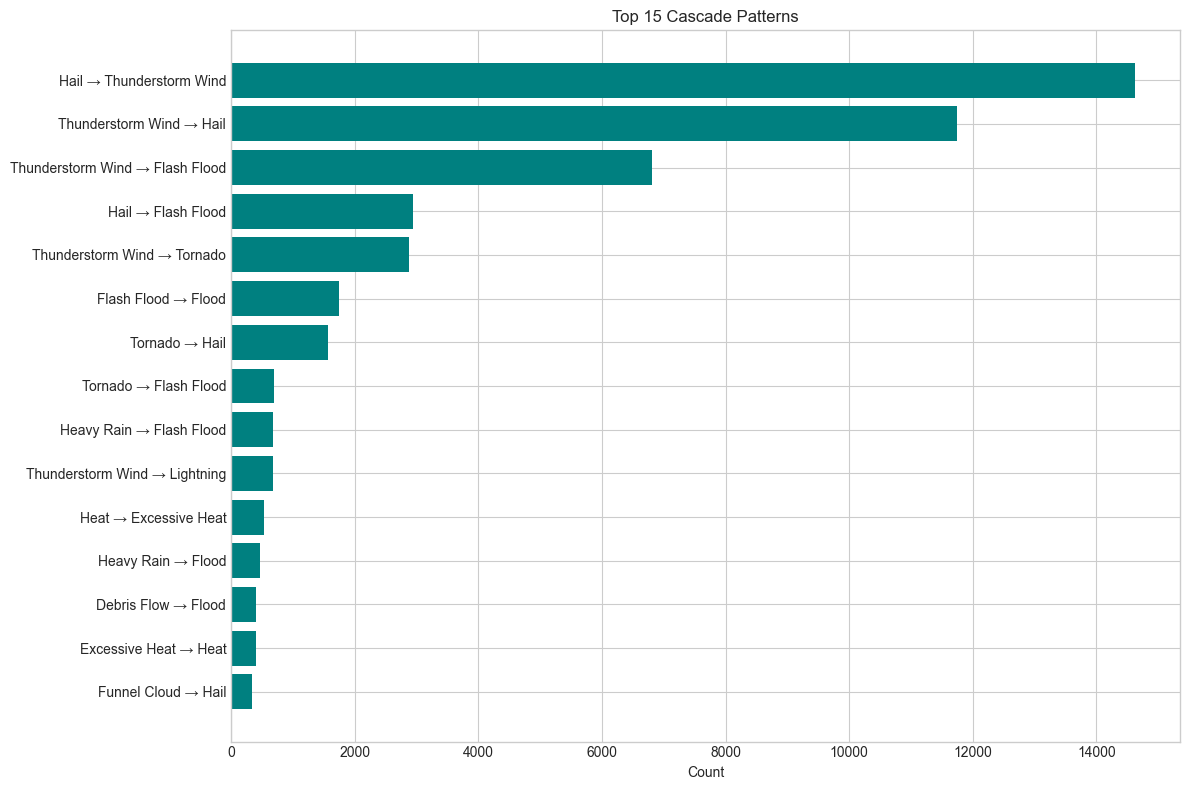

In [204]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
top_15 = cascade_types.head(15)
labels = [f"{p} → {s}" for p, s in top_15.index]
ax.barh(labels[::-1], top_15.values[::-1], color='teal')
ax.set_xlabel('Count')
ax.set_title('Top 15 Cascade Patterns')
plt.tight_layout()
plt.show()

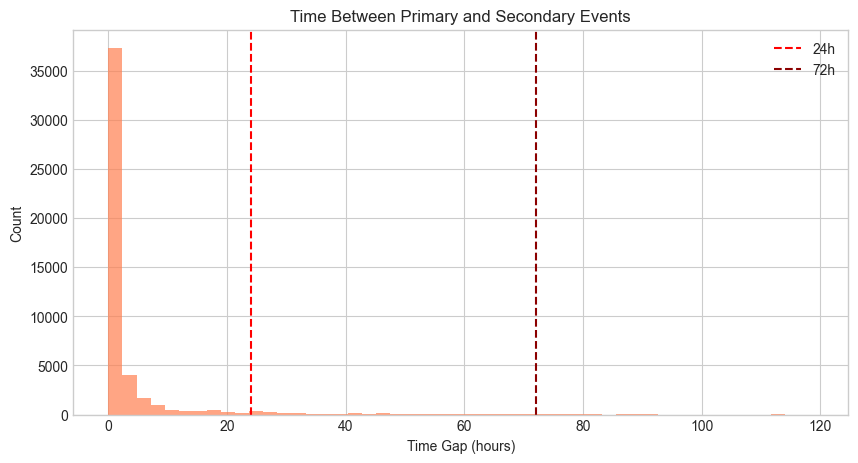

Median: 0.6h
Mean: 3.7h


In [205]:
# Time gap distribution
fig, ax = plt.subplots(figsize=(10, 5))
cascade_df['time_gap_hours'].hist(bins=50, ax=ax, color='coral', alpha=0.7)
ax.axvline(24, color='red', linestyle='--', label='24h')
ax.axvline(72, color='darkred', linestyle='--', label='72h')
ax.set_xlabel('Time Gap (hours)')
ax.set_ylabel('Count')
ax.set_title('Time Between Primary and Secondary Events')
ax.legend()
plt.show()

print(f"Median: {cascade_df['time_gap_hours'].median():.1f}h")
print(f"Mean: {cascade_df['time_gap_hours'].mean():.1f}h")

---
# Part 3: Create Multilabel Targets

In [206]:
from src.labeling import create_cascade_labels, get_label_summary, get_all_classes, to_binary_matrix

# Create multilabel targets
df_labeled = create_cascade_labels(df, cascades)

# What does the labeled dataframe look like?
df_labeled[['EVENT_ID', 'EVENT_TYPE', 'STATE', 'target', 'is_cascade_result']].head(10)

,EVENT_ID,EVENT_TYPE,STATE,target,is_cascade_result
0,902190,Thunderstorm Wind,GEORGIA,[],False
1,898391,Hail,KANSAS,[],False
2,899120,Hail,KANSAS,[],False
3,898383,Thunderstorm Wind,KANSAS,[],False
4,898388,Hail,KANSAS,[],False
5,899127,Hail,KANSAS,[],False
6,899011,Hail,COLORADO,[],False
7,901352,Hail,COLORADO,[],False
8,901350,Hail,COLORADO,[],False
9,904300,High Wind,KANSAS,[],False


In [207]:
# Summary
summary = get_label_summary(df_labeled)
print("Label Summary:")
for k, v in summary.items():
    if k != 'class_counts':
        print(f"  {k}: {v}")

print(f"\nClass Distribution:")
for cls, count in list(summary['class_counts'].items())[:15]:
    print(f"  {cls}: {count:,}")

Label Summary:
  total_events: 268150
  events_with_cascade: 23196
  cascade_rate: 8.65%
  num_classes: 25

Class Distribution:
  Thunderstorm Wind: 7,142
  Hail: 6,911
  Flash Flood: 5,515
  Tornado: 2,253
  Flood: 1,414
  Lightning: 662
  Excessive Heat: 484
  Heat: 341
  Debris Flow: 271
  Waterspout: 98
  Marine Thunderstorm Wind: 88
  Blizzard: 75
  Marine Hail: 46
  Dust Storm: 37
  Ice Storm: 23


In [208]:
# Sample events with cascades
with_cascades = df_labeled[df_labeled['target'].apply(len) > 0]
print(f"Events with cascades: {len(with_cascades):,} ({len(with_cascades)/len(df_labeled)*100:.2f}%)")

with_cascades[['EVENT_TYPE', 'STATE', 'target', 'TOTAL_DAMAGE_USD', 'FATALITY_COUNT']].head(15)

Events with cascades: 23,196 (8.65%)


,EVENT_TYPE,STATE,target,TOTAL_DAMAGE_USD,FATALITY_COUNT
15,Hail,KANSAS,[Thunderstorm Wind],0.0,0
33,Hail,KANSAS,[Thunderstorm Wind],0.0,0
50,Hail,NEBRASKA,[Thunderstorm Wind],0.0,0
54,Thunderstorm Wind,NEBRASKA,[Hail],0.0,0
72,Thunderstorm Wind,OHIO,[Hail],5000.0,0
79,Thunderstorm Wind,OHIO,[Hail],0.0,0
87,Thunderstorm Wind,OHIO,[Hail],1000.0,0
89,Thunderstorm Wind,OHIO,[Hail],6000.0,0
90,Hail,OHIO,[Thunderstorm Wind],0.0,0
100,Thunderstorm Wind,OHIO,[Hail],1000.0,0


In [209]:
# Convert to binary matrix for sklearn
classes = get_all_classes(df_labeled)
print(f"Classes ({len(classes)}): {classes}")

Classes (25): ['Avalanche', 'Blizzard', 'Coastal Flood', 'Debris Flow', 'Dust Storm', 'Excessive Heat', 'Extreme Cold/Wind Chill', 'Flash Flood', 'Flood', 'Hail', 'Heat', 'Heavy Rain', 'Heavy Snow', 'High Surf', 'Ice Storm', 'Lightning', 'Marine Hail', 'Marine Thunderstorm Wind', 'Rip Current', 'Storm Surge/Tide', 'Thunderstorm Wind', 'Tornado', 'Waterspout', 'Wildfire', 'Winter Weather']


In [210]:
y_binary = to_binary_matrix(df_labeled, classes)
print(f"Binary matrix shape: {y_binary.shape}")
y_binary.head(10)

Binary matrix shape: (268150, 25)


,Avalanche,Blizzard,Coastal Flood,Debris Flow,Dust Storm,Excessive Heat,Extreme Cold/Wind Chill,Flash Flood,Flood,Hail,Heat,Heavy Rain,Heavy Snow,High Surf,Ice Storm,Lightning,Marine Hail,Marine Thunderstorm Wind,Rip Current,Storm Surge/Tide,Thunderstorm Wind,Tornado,Waterspout,Wildfire,Winter Weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


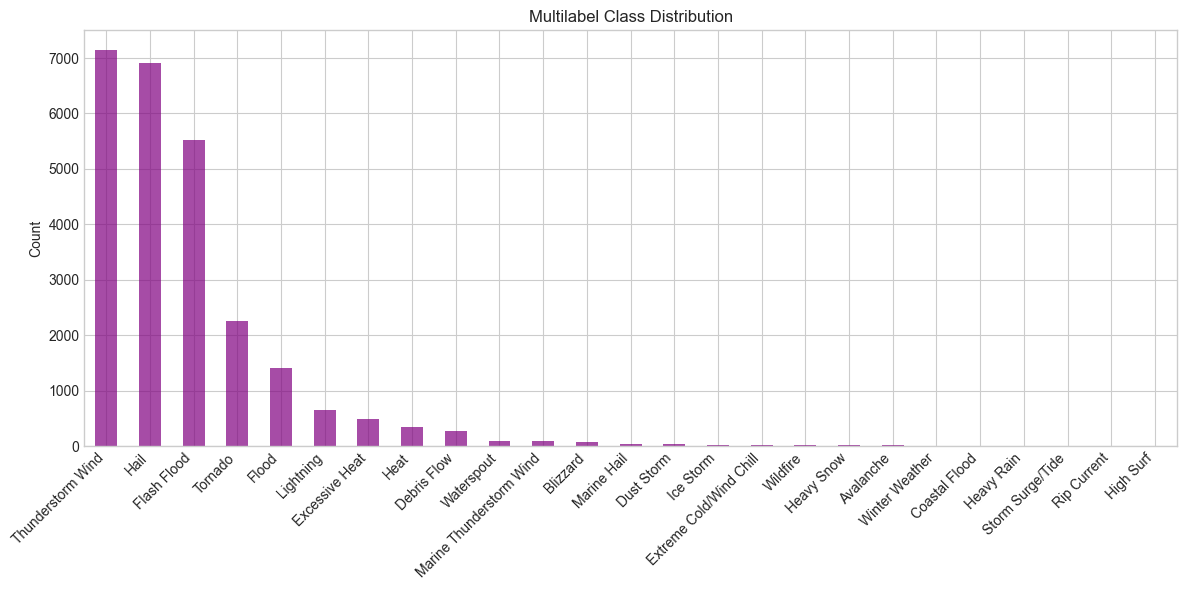

In [211]:
# Class imbalance visualization
class_totals = y_binary.sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
class_totals.plot(kind='bar', ax=ax, color='purple', alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('Multilabel Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Part 5: Pattern Analysis

Analyzing which event type pairs occur most frequently and visualizing cascade relationships.

In [213]:
# Setup: Create results directory for saving outputs
import os

RESULTS_DIR = '../results/cascade_eda'
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f'Results will be saved to: {os.path.abspath(RESULTS_DIR)}')

Results will be saved to: /Users/shikhabhat/Documents/CMU/Classes/Spring 2026/10-718 MLiP/Project/cascading-disaster-prediction/results


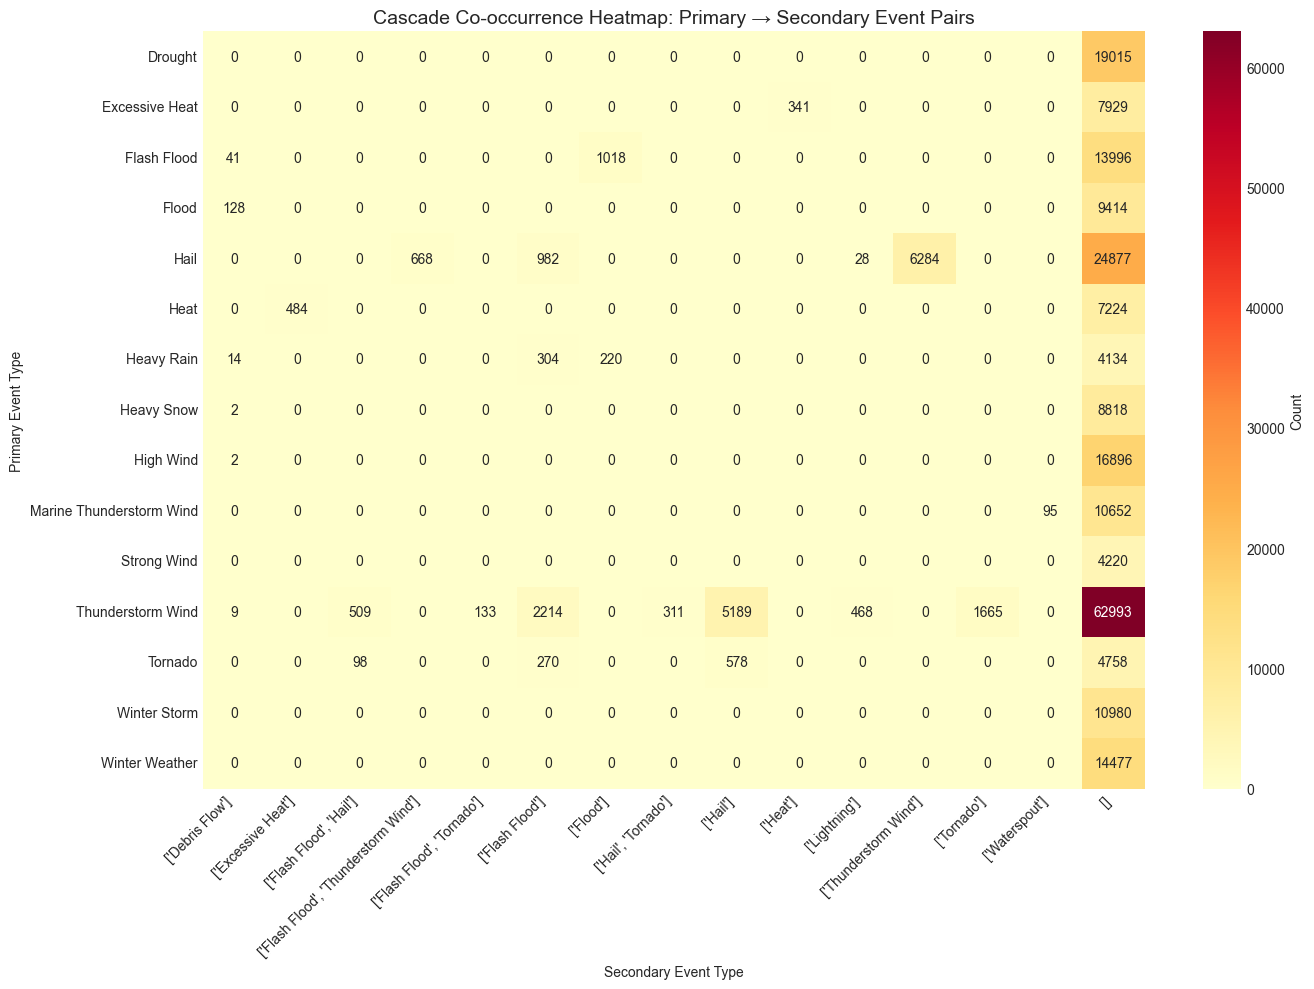

Total cascade pairs analyzed: 268,150

Top 10 primary→secondary pairs:
Primary                   Secondary
Thunderstorm Wind         []           62993
Hail                      []           24877
Drought                   []           19015
High Wind                 []           16896
Winter Weather            []           14477
Flash Flood               []           13996
Winter Storm              []           10980
Marine Thunderstorm Wind  []           10652
Flood                     []            9414
Heavy Snow                []            8818
dtype: int64


In [214]:
# Co-occurrence Heatmap: which primary→secondary pairs are most common?
import seaborn as sns

# Get cascade events (events with a target)
cascade_events = df_labeled[df_labeled['target'].notna() & (df_labeled['target'] != '')].copy()

# For multi-label targets, split them
def explode_targets(row):
    target = row['target']
    # Handle various null-like values
    if target is None or (isinstance(target, float) and pd.isna(target)) or target == '':
        return []
    targets = str(target).split('|')
    return [(row['EVENT_TYPE'], t.strip()) for t in targets if t.strip()]

pairs = []
for _, row in cascade_events.iterrows():
    pairs.extend(explode_targets(row))

# Create a dataframe of pairs
pairs_df = pd.DataFrame(pairs, columns=['Primary', 'Secondary'])

# Create co-occurrence matrix
cooccurrence = pairs_df.groupby(['Primary', 'Secondary']).size().unstack(fill_value=0)

# Plot heatmap (top 15 primaries and secondaries by frequency)
top_primaries = pairs_df['Primary'].value_counts().head(15).index
top_secondaries = pairs_df['Secondary'].value_counts().head(15).index

# Filter to top pairs
cooc_filtered = cooccurrence.loc[
    cooccurrence.index.isin(top_primaries),
    cooccurrence.columns.isin(top_secondaries)
]

plt.figure(figsize=(14, 10))
sns.heatmap(cooc_filtered, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Cascade Co-occurrence Heatmap: Primary → Secondary Event Pairs', fontsize=14)
plt.xlabel('Secondary Event Type')
plt.ylabel('Primary Event Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/cooccurrence_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Total cascade pairs analyzed: {len(pairs_df):,}")
print(f"\nTop 10 primary→secondary pairs:")
print(pairs_df.groupby(['Primary', 'Secondary']).size().sort_values(ascending=False).head(10))

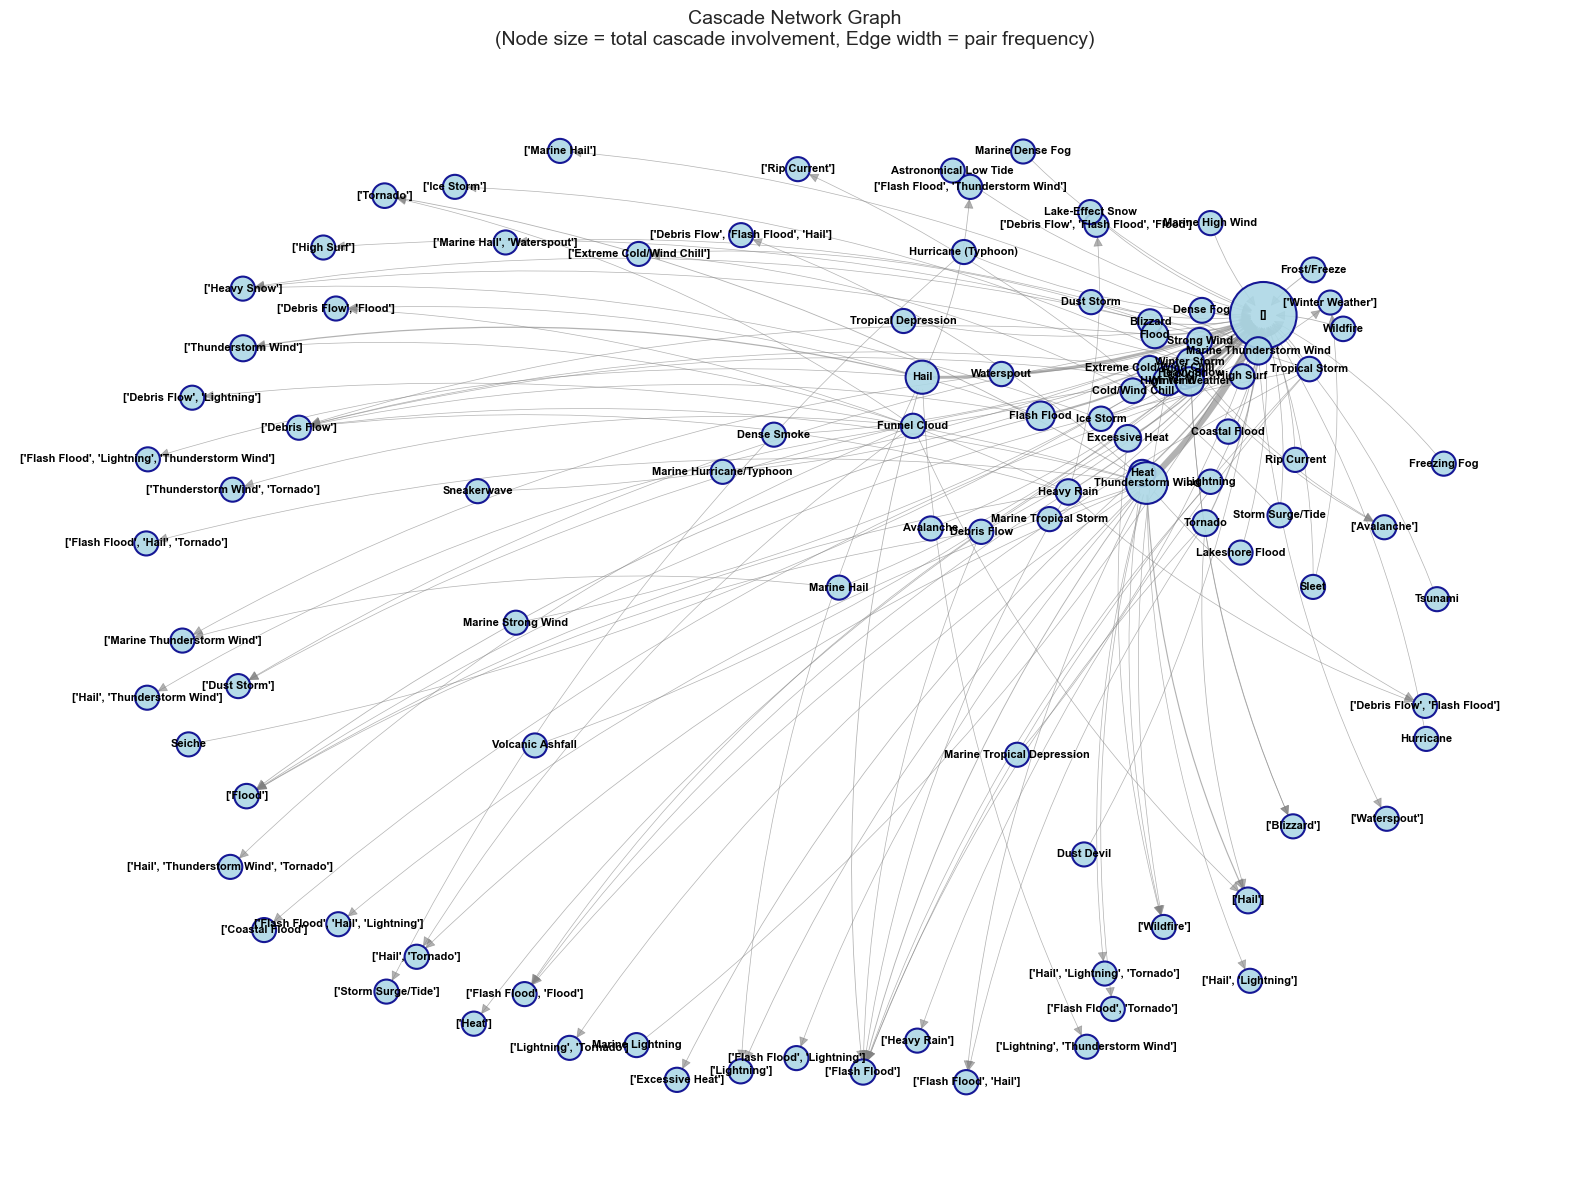

Network Statistics:
  - Nodes (event types): 103
  - Edges (cascade pairs): 137
  - Total cascade links: 268,150


In [215]:
# Network Graph: visualize cascade relationships as directed graph
import networkx as nx

# Create directed graph from pairs
G = nx.DiGraph()

# Add edges with weights (counts)
edge_weights = pairs_df.groupby(['Primary', 'Secondary']).size().reset_index(name='weight')
for _, row in edge_weights.iterrows():
    G.add_edge(row['Primary'], row['Secondary'], weight=row['weight'])

# Calculate node sizes based on total connections
node_sizes = {}
for node in G.nodes():
    node_sizes[node] = G.in_degree(node, weight='weight') + G.out_degree(node, weight='weight')

# Normalize sizes
max_size = max(node_sizes.values()) if node_sizes else 1
sizes = [300 + 2000 * (node_sizes.get(n, 0) / max_size) for n in G.nodes()]

# Edge widths based on weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights) if weights else 1
edge_widths = [0.5 + 4 * (w / max_weight) for w in weights]

# Plot
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue', 
                       edgecolors='darkblue', linewidths=1.5, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6, 
                       edge_color='gray', arrows=True, arrowsize=15,
                       connectionstyle='arc3,rad=0.1')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Cascade Network Graph\n(Node size = total cascade involvement, Edge width = pair frequency)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/cascade_network.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Network Statistics:")
print(f"  - Nodes (event types): {G.number_of_nodes()}")
print(f"  - Edges (cascade pairs): {G.number_of_edges()}")
print(f"  - Total cascade links: {sum(weights):,}")

## Part 6: Temporal Analysis

Understanding timing patterns in cascade events.

<Figure size 1400x600 with 0 Axes>

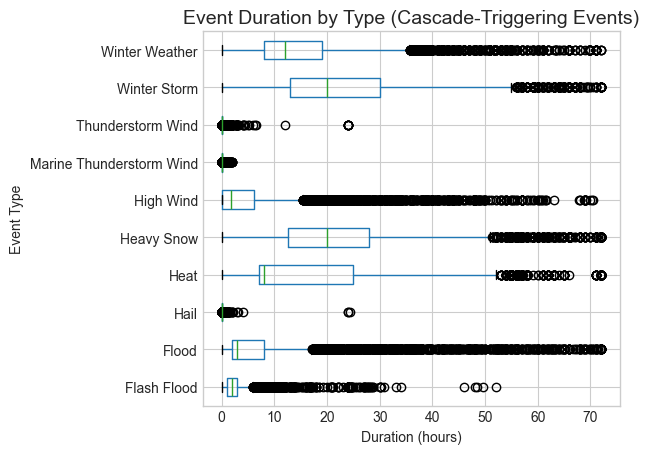

Note: This shows event durations, not time gaps between cascade pairs.
Time gaps between primary and secondary events require cascade tracking data.


In [217]:
# Time Gaps by Cascade Type
# Since we don't have explicit cascade pairings with timestamps in this context,
# we'll visualize the typical duration of events by type instead

# Check if we have BEGIN_DATETIME
if 'BEGIN_DATETIME' in df.columns and 'END_DATETIME' in df.columns:
    df_time = df.copy()
    df_time['BEGIN_DATETIME'] = pd.to_datetime(df_time['BEGIN_DATETIME'], errors='coerce')
    df_time['END_DATETIME'] = pd.to_datetime(df_time['END_DATETIME'], errors='coerce')
    df_time['duration_hours'] = (df_time['END_DATETIME'] - df_time['BEGIN_DATETIME']).dt.total_seconds() / 3600
    
    # Filter valid durations (0 to 72 hours)
    df_time = df_time[(df_time['duration_hours'] >= 0) & (df_time['duration_hours'] <= 72)]
    
    # Get cascade-triggering events
    cascade_ids = cascade_events['EVENT_ID'].values
    df_cascade_time = df_time[df_time['EVENT_ID'].isin(cascade_ids)]
    
    # Event duration by type
    top_types = df_cascade_time['EVENT_TYPE'].value_counts().head(10).index
    df_filtered = df_cascade_time[df_cascade_time['EVENT_TYPE'].isin(top_types)]
    
    plt.figure(figsize=(14, 6))
    df_filtered.boxplot(column='duration_hours', by='EVENT_TYPE', vert=False)
    plt.title('Event Duration by Type (Cascade-Triggering Events)', fontsize=14)
    plt.xlabel('Duration (hours)')
    plt.ylabel('Event Type')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/event_duration_by_type.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Note: This shows event durations, not time gaps between cascade pairs.")
    print("Time gaps between primary and secondary events require cascade tracking data.")
else:
    print("Note: BEGIN_DATETIME/END_DATETIME columns not available for duration analysis.")

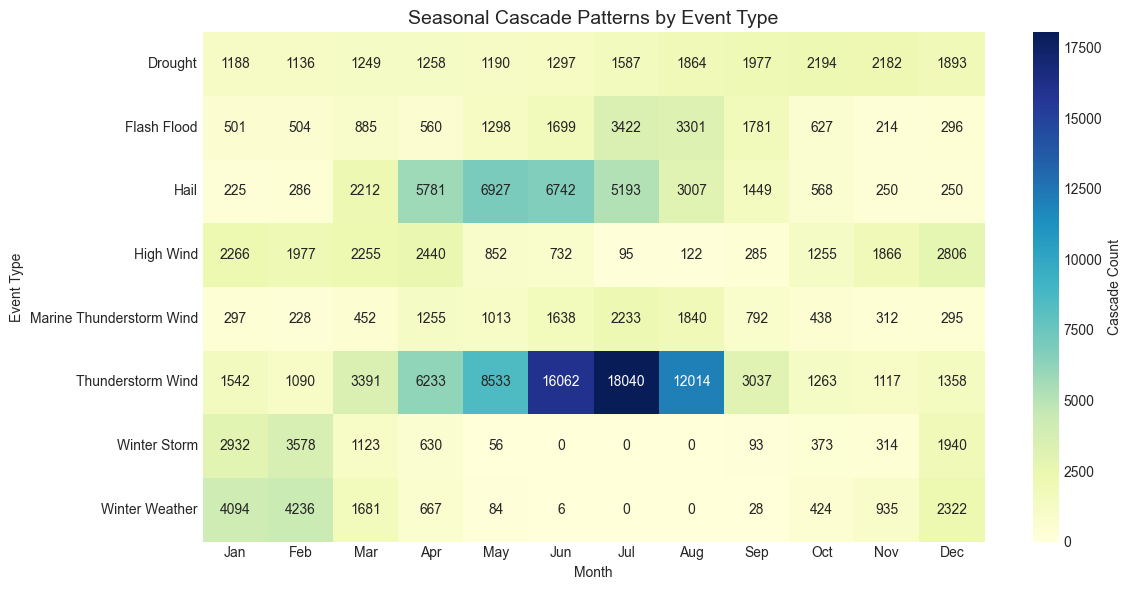

In [219]:
# Seasonal Patterns: cascade frequency by month

# Check for datetime column
if 'BEGIN_DATETIME' in df.columns:
    df['BEGIN_DATETIME'] = pd.to_datetime(df['BEGIN_DATETIME'], errors='coerce')
    df['month'] = df['BEGIN_DATETIME'].dt.month
    
    # Get cascade events
    cascade_mask = df['EVENT_ID'].isin(cascade_events['EVENT_ID'])
    
    # Monthly pattern for cascades
    cascade_df = df[cascade_mask].copy()
    
    # Create a pivot table: month vs primary event type
    cascade_df = cascade_df.merge(
        cascade_events[['EVENT_ID', 'target']], on='EVENT_ID', how='left'
    )
    
    monthly_counts = cascade_df.groupby(['month', 'EVENT_TYPE']).size().unstack(fill_value=0)
    
    # Get top event types
    top_types = cascade_df['EVENT_TYPE'].value_counts().head(8).index
    monthly_filtered = monthly_counts[monthly_counts.columns.intersection(top_types)]
    
    # Plot seasonal heatmap
    plt.figure(figsize=(12, 6))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_filtered.index = [month_names[i-1] for i in monthly_filtered.index]
    
    sns.heatmap(monthly_filtered.T, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Cascade Count'})
    plt.title('Seasonal Cascade Patterns by Event Type', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Event Type')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/seasonal_cascade_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Note: BEGIN_DATETIME column not available for seasonal analysis.")

## Part 7: Geographic Analysis

Examining where cascades occur most frequently.

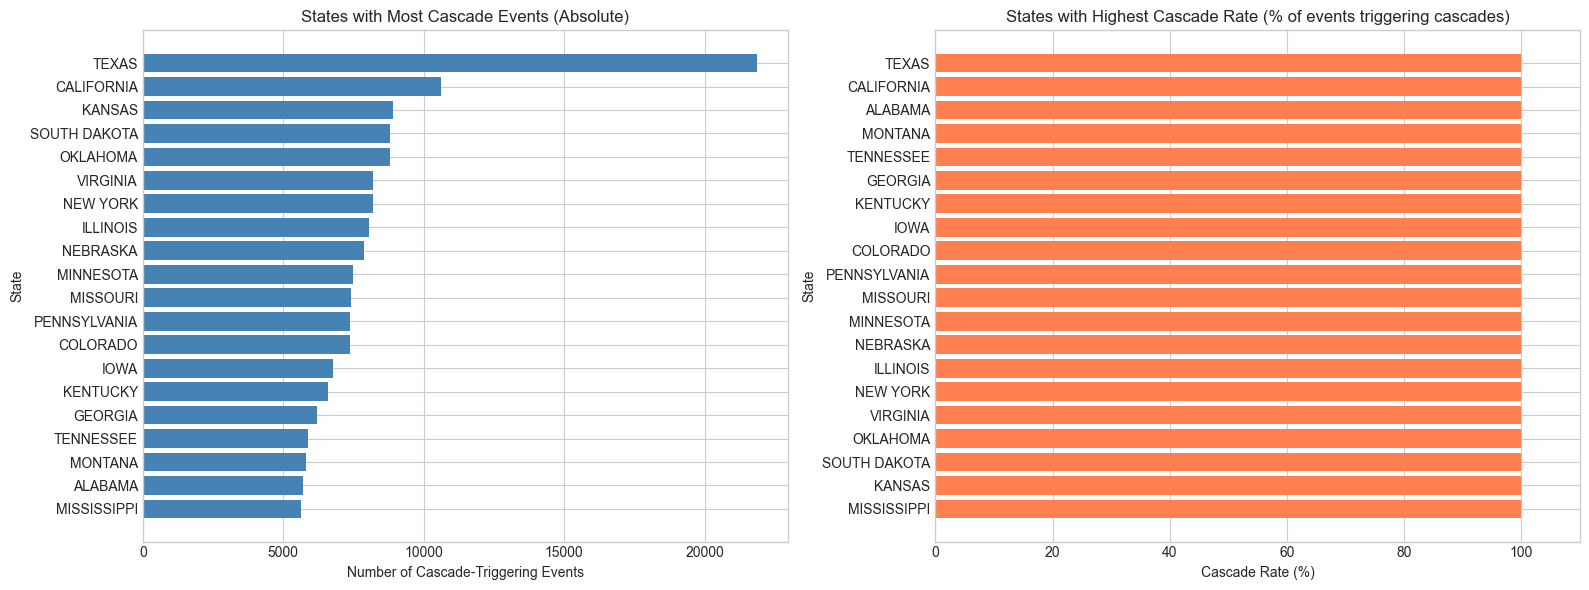


Top 10 states by cascade count:
STATE
TEXAS           21854
CALIFORNIA      10628
KANSAS           8905
SOUTH DAKOTA     8799
OKLAHOMA         8795
VIRGINIA         8194
NEW YORK         8179
ILLINOIS         8060
NEBRASKA         7869
MINNESOTA        7469
Name: count, dtype: int64

Top 10 states by cascade rate:
  TEXAS: 100.00%
  CALIFORNIA: 100.00%
  ALABAMA: 100.00%
  MONTANA: 100.00%
  TENNESSEE: 100.00%
  GEORGIA: 100.00%
  KENTUCKY: 100.00%
  IOWA: 100.00%
  COLORADO: 100.00%
  PENNSYLVANIA: 100.00%


In [220]:
# States with Highest Cascade Rates

# Merge state info
cascade_with_state = cascade_events.copy()

# Count cascades by state
state_counts = cascade_with_state['STATE'].value_counts().head(20)

# Total events by state for rate calculation
total_by_state = df_labeled['STATE'].value_counts()

# Calculate cascade rate (% of events that are cascade triggers)
# Only calculate for states that appear in both
common_states = state_counts.index.intersection(total_by_state.index)
cascade_rate = (state_counts[common_states] / total_by_state[common_states] * 100).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
axes[0].barh(state_counts.index[::-1], state_counts.values[::-1], color='steelblue')
axes[0].set_xlabel('Number of Cascade-Triggering Events')
axes[0].set_title('States with Most Cascade Events (Absolute)')
axes[0].set_ylabel('State')

# Cascade rate - show top 20 by rate
top_rate_states = cascade_rate.head(20)
axes[1].barh(top_rate_states.index[::-1], top_rate_states.values[::-1], color='coral')
axes[1].set_xlabel('Cascade Rate (%)')
axes[1].set_title('States with Highest Cascade Rate (% of events triggering cascades)')
axes[1].set_ylabel('State')
axes[1].set_xlim(0, max(top_rate_states.values) * 1.1)  # Add 10% margin

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/state_cascade_rates.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 states by cascade count:")
print(state_counts.head(10))
print("\nTop 10 states by cascade rate:")
for state, rate in cascade_rate.head(10).items():
    print(f"  {state}: {rate:.2f}%")

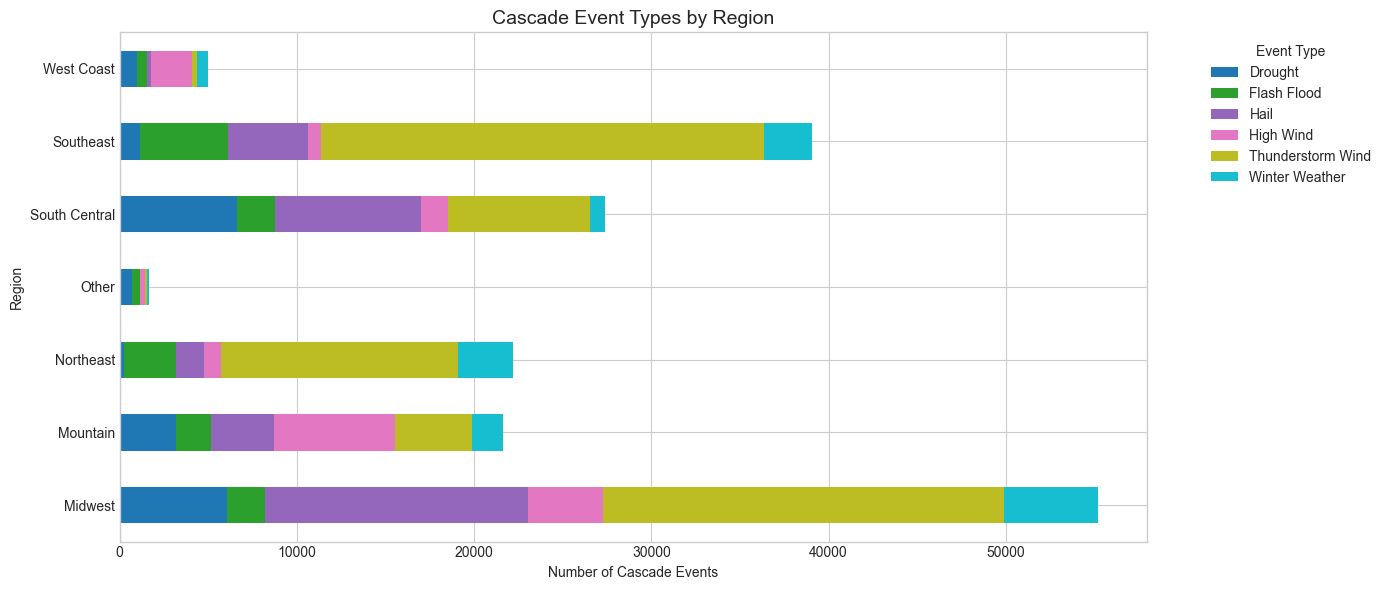


Cascade events by region:
region
Midwest          77588
Southeast        56101
South Central    40485
Mountain         32224
Northeast        30775
Other            17325
West Coast       13652
Name: count, dtype: int64


In [221]:
# Regional Cascade Patterns

# Define US regions
regions = {
    'West Coast': ['CALIFORNIA', 'OREGON', 'WASHINGTON'],
    'Mountain': ['MONTANA', 'IDAHO', 'WYOMING', 'COLORADO', 'UTAH', 'NEVADA', 'ARIZONA', 'NEW MEXICO'],
    'Midwest': ['NORTH DAKOTA', 'SOUTH DAKOTA', 'NEBRASKA', 'KANSAS', 'MINNESOTA', 'IOWA', 'MISSOURI', 
               'WISCONSIN', 'ILLINOIS', 'MICHIGAN', 'INDIANA', 'OHIO'],
    'South Central': ['TEXAS', 'OKLAHOMA', 'ARKANSAS', 'LOUISIANA'],
    'Southeast': ['KENTUCKY', 'TENNESSEE', 'MISSISSIPPI', 'ALABAMA', 'GEORGIA', 'FLORIDA', 
                  'SOUTH CAROLINA', 'NORTH CAROLINA', 'VIRGINIA', 'WEST VIRGINIA'],
    'Northeast': ['MAINE', 'NEW HAMPSHIRE', 'VERMONT', 'MASSACHUSETTS', 'RHODE ISLAND', 'CONNECTICUT',
                 'NEW YORK', 'NEW JERSEY', 'PENNSYLVANIA', 'DELAWARE', 'MARYLAND'],
    'Gulf Coast': ['TEXAS', 'LOUISIANA', 'MISSISSIPPI', 'ALABAMA', 'FLORIDA'],
    'Tornado Alley': ['TEXAS', 'OKLAHOMA', 'KANSAS', 'NEBRASKA', 'SOUTH DAKOTA', 'IOWA']
}

def get_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Other'

# Assign regions (using primary region - avoid overlap)
primary_regions = {
    'West Coast': ['CALIFORNIA', 'OREGON', 'WASHINGTON'],
    'Mountain': ['MONTANA', 'IDAHO', 'WYOMING', 'COLORADO', 'UTAH', 'NEVADA', 'ARIZONA', 'NEW MEXICO'],
    'Midwest': ['NORTH DAKOTA', 'SOUTH DAKOTA', 'NEBRASKA', 'KANSAS', 'MINNESOTA', 'IOWA', 'MISSOURI', 
               'WISCONSIN', 'ILLINOIS', 'MICHIGAN', 'INDIANA', 'OHIO'],
    'South Central': ['TEXAS', 'OKLAHOMA', 'ARKANSAS', 'LOUISIANA'],
    'Southeast': ['KENTUCKY', 'TENNESSEE', 'MISSISSIPPI', 'ALABAMA', 'GEORGIA', 'FLORIDA', 
                  'SOUTH CAROLINA', 'NORTH CAROLINA', 'VIRGINIA', 'WEST VIRGINIA'],
    'Northeast': ['MAINE', 'NEW HAMPSHIRE', 'VERMONT', 'MASSACHUSETTS', 'RHODE ISLAND', 'CONNECTICUT',
                 'NEW YORK', 'NEW JERSEY', 'PENNSYLVANIA', 'DELAWARE', 'MARYLAND'],
}

cascade_with_state['region'] = cascade_with_state['STATE'].apply(
    lambda x: next((r for r, states in primary_regions.items() if x in states), 'Other')
)

# Regional cascade types
regional_types = cascade_with_state.groupby(['region', 'EVENT_TYPE']).size().unstack(fill_value=0)

# Get top event types overall
top_types = cascade_with_state['EVENT_TYPE'].value_counts().head(6).index
regional_filtered = regional_types[regional_types.columns.intersection(top_types)]

# Plot stacked bar chart
regional_filtered.plot(kind='barh', stacked=True, figsize=(14, 6), colormap='tab10')
plt.title('Cascade Event Types by Region', fontsize=14)
plt.xlabel('Number of Cascade Events')
plt.ylabel('Region')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/regional_cascade_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCascade events by region:")
print(cascade_with_state['region'].value_counts())

## Part 8: Impact Analysis

Comparing impacts of cascade events vs isolated events.

Total events: 268,150
Events with valid target: 23,196
Events that are cascade results: 21,492
Total cascade events: 38,763
Isolated events: 229,387


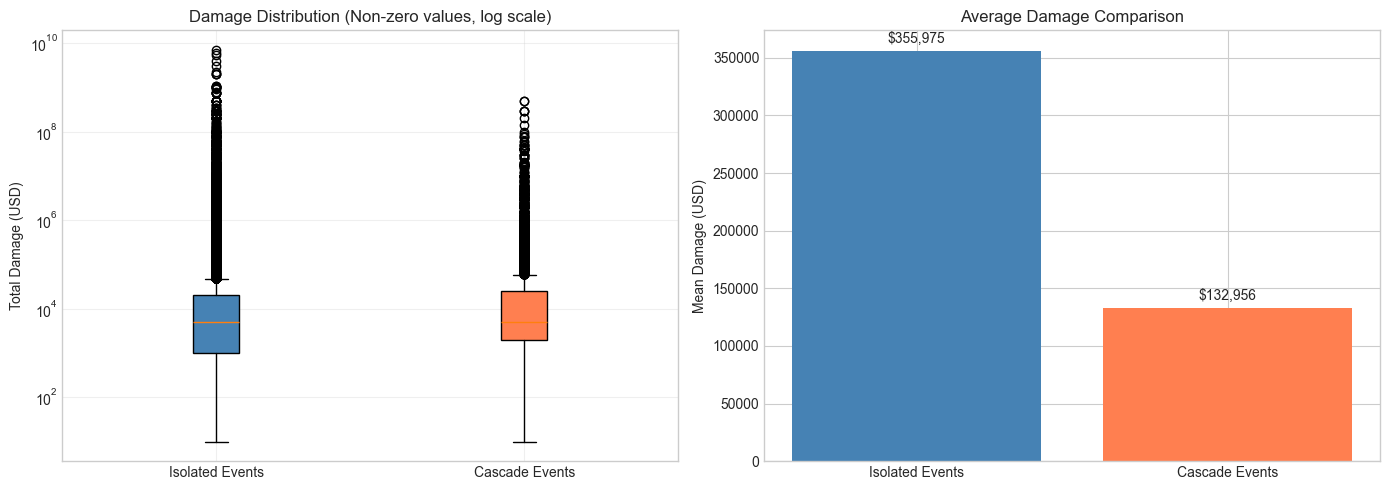


Damage Comparison Summary:
Metric                      Isolated         Cascade
--------------------------------------------------
Event Count                  229,387          38,763
Non-zero Count                41,525           9,560
Mean Damage          $      355,975 $      132,956
Median Damage        $            0 $            0
Total Damage         $81,656,071,870 $5,153,775,870


In [222]:
# Compare Damage: Cascade Events vs Isolated Events

# Helper to check if target is valid (non-empty)
def has_valid_target(target):
    if target is None:
        return False
    if isinstance(target, float) and pd.isna(target):
        return False
    target_str = str(target).strip()
    if target_str in ['', '[]', 'nan', 'None', 'NaN']:
        return False
    return True

# Identify cascade vs isolated events
# Cascade = either triggers a cascade (has valid target) OR is a result of cascade
has_target = df_labeled['target'].apply(has_valid_target)
is_result = df_labeled['is_cascade_result'] == True

df_labeled['is_cascade'] = has_target | is_result

# Debug info
print(f"Total events: {len(df_labeled):,}")
print(f"Events with valid target: {has_target.sum():,}")
print(f"Events that are cascade results: {is_result.sum():,}")
print(f"Total cascade events: {df_labeled['is_cascade'].sum():,}")
print(f"Isolated events: {(~df_labeled['is_cascade']).sum():,}")

# Compare damage - filter out zeros and NaN for meaningful comparison
cascade_damage = df_labeled[df_labeled['is_cascade']]['TOTAL_DAMAGE_USD'].dropna()
isolated_damage = df_labeled[~df_labeled['is_cascade']]['TOTAL_DAMAGE_USD'].dropna()

# Filter to positive values for log-scale boxplot
cascade_nonzero = cascade_damage[cascade_damage > 0]
isolated_nonzero = isolated_damage[isolated_damage > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot comparison (log scale for better visualization)
if len(isolated_nonzero) > 0 and len(cascade_nonzero) > 0:
    bp = axes[0].boxplot([isolated_nonzero.values, cascade_nonzero.values], 
                         tick_labels=['Isolated Events', 'Cascade Events'],
                         patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    axes[0].set_ylabel('Total Damage (USD)')
    axes[0].set_yscale('log')
    axes[0].set_title('Damage Distribution (Non-zero values, log scale)')
    axes[0].grid(True, alpha=0.3)
elif len(cascade_nonzero) > 0:
    axes[0].boxplot([cascade_nonzero.values], tick_labels=['Cascade Events'], patch_artist=True)
    axes[0].set_ylabel('Total Damage (USD)')
    axes[0].set_yscale('log')
    axes[0].set_title('Damage Distribution (Cascade only - no isolated events with damage)')
else:
    axes[0].text(0.5, 0.5, 'Insufficient damage data', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Damage Distribution')

# Bar chart of means
isolated_mean = isolated_damage.mean() if len(isolated_damage) > 0 else 0
cascade_mean = cascade_damage.mean() if len(cascade_damage) > 0 else 0
means = [isolated_mean if pd.notna(isolated_mean) else 0, cascade_mean if pd.notna(cascade_mean) else 0]
colors = ['steelblue', 'coral']
bars = axes[1].bar(['Isolated Events', 'Cascade Events'], means, color=colors)
axes[1].set_ylabel('Mean Damage (USD)')
axes[1].set_title('Average Damage Comparison')
for idx, v in enumerate(means):
    if v > 0:
        axes[1].text(idx, v + max(means)*0.02, f'${v:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/cascade_vs_isolated_damage.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nDamage Comparison Summary:")
print(f"{'Metric':<20} {'Isolated':>15} {'Cascade':>15}")
print("-" * 50)
print(f"{'Event Count':<20} {len(isolated_damage):>15,} {len(cascade_damage):>15,}")
print(f"{'Non-zero Count':<20} {len(isolated_nonzero):>15,} {len(cascade_nonzero):>15,}")
if len(isolated_damage) > 0:
    print(f"{'Mean Damage':<20} ${isolated_damage.mean():>13,.0f} ${cascade_damage.mean():>13,.0f}")
    print(f"{'Median Damage':<20} ${isolated_damage.median():>13,.0f} ${cascade_damage.median():>13,.0f}")
    print(f"{'Total Damage':<20} ${isolated_damage.sum():>13,.0f} ${cascade_damage.sum():>13,.0f}")
else:
    print(f"{'Mean Damage':<20} {'N/A':>15} ${cascade_damage.mean():>13,.0f}")

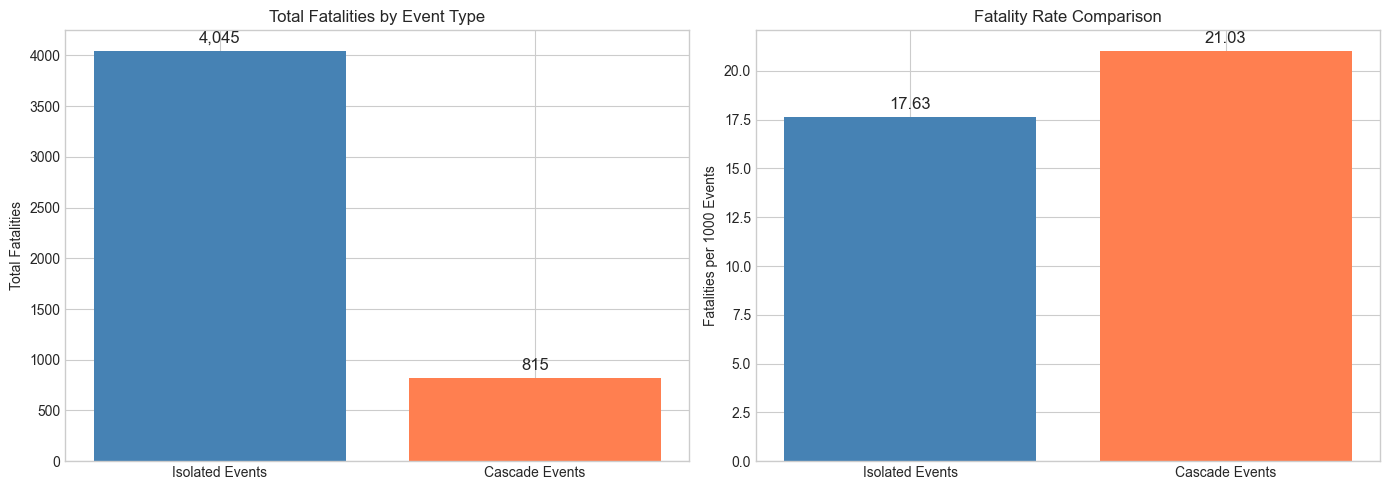


Fatality Summary:
  Isolated events: 4,045 fatalities across 229,387 events
  Cascade events: 815 fatalities across 38,763 events


In [223]:
# Fatalities in Cascade Chains

# Compare fatalities
cascade_fatalities = df_labeled[df_labeled['is_cascade']]['FATALITY_COUNT'].fillna(0)
isolated_fatalities = df_labeled[~df_labeled['is_cascade']]['FATALITY_COUNT'].fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total fatalities
fatality_totals = [int(isolated_fatalities.sum()), int(cascade_fatalities.sum())]
colors = ['steelblue', 'coral']
axes[0].bar(['Isolated Events', 'Cascade Events'], fatality_totals, color=colors)
axes[0].set_ylabel('Total Fatalities')
axes[0].set_title('Total Fatalities by Event Type')
for i, v in enumerate(fatality_totals):
    axes[0].text(i, v + max(fatality_totals)*0.02, f'{v:,}', ha='center', fontsize=12)

# Fatality rate (fatalities per 1000 events) - handle division by zero
n_isolated = len(isolated_fatalities)
n_cascade = len(cascade_fatalities)
isolated_rate = (isolated_fatalities.sum() / n_isolated * 1000) if n_isolated > 0 else 0
cascade_rate = (cascade_fatalities.sum() / n_cascade * 1000) if n_cascade > 0 else 0
rates = [isolated_rate, cascade_rate]

axes[1].bar(['Isolated Events', 'Cascade Events'], rates, color=colors)
axes[1].set_ylabel('Fatalities per 1000 Events')
axes[1].set_title('Fatality Rate Comparison')
for i, v in enumerate(rates):
    if v > 0:
        axes[1].text(i, v + max(rates)*0.02, f'{v:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/cascade_fatalities.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFatality Summary:")
print(f"  Isolated events: {int(isolated_fatalities.sum()):,} fatalities across {n_isolated:,} events")
print(f"  Cascade events: {int(cascade_fatalities.sum()):,} fatalities across {n_cascade:,} events")

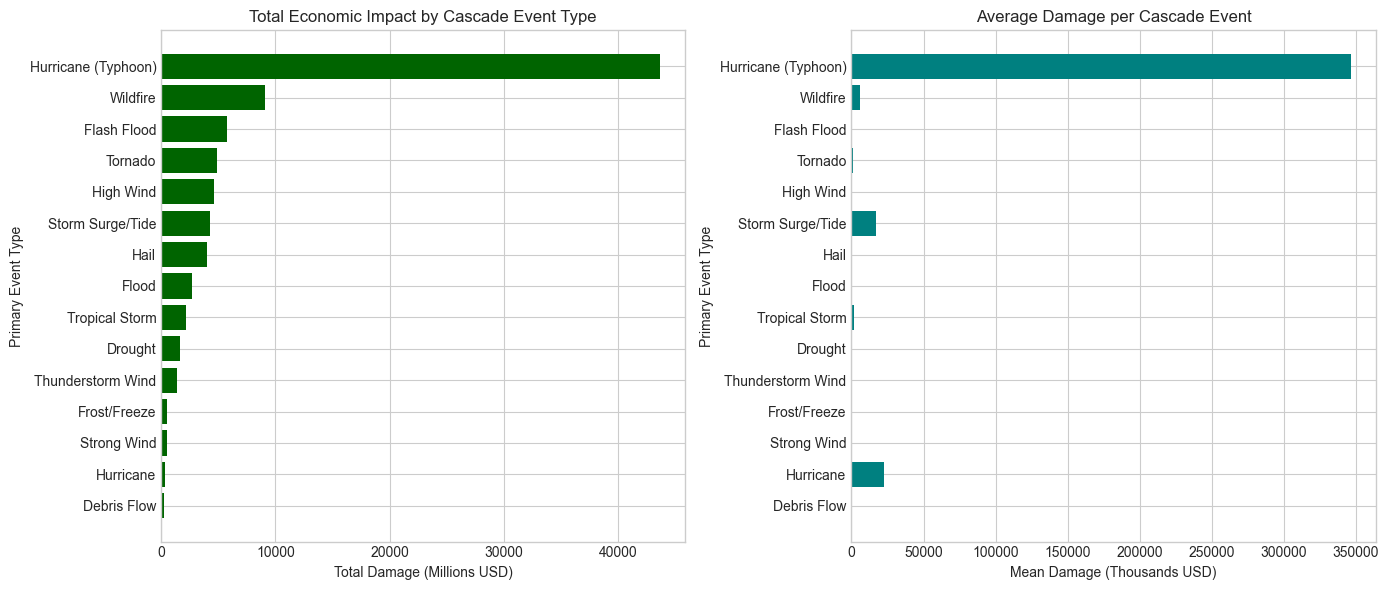


Top 10 cascade types by total economic impact:
                    Total Damage   Mean Damage  Count
EVENT_TYPE                                           
Hurricane (Typhoon)   $43666.73M  $346,561,341    126
Wildfire               $9100.21M    $6,136,355   1483
Flash Flood            $5785.99M      $383,483  15088
Tornado                $4848.77M      $850,065   5704
High Wind              $4659.89M      $274,903  16951
Storm Surge/Tide       $4292.13M   $16,898,164    254
Hail                   $3997.90M      $121,554  32890
Flood                  $2710.23M      $284,031   9542
Tropical Storm         $2131.82M    $1,474,290   1446
Drought                $1637.51M       $86,117  19015


In [224]:
# Economic Impact by Cascade Type

# Merge damage info back  
cascade_with_damage = cascade_events.merge(
    df_labeled[['EVENT_ID', 'TOTAL_DAMAGE_USD']], on='EVENT_ID', how='left', suffixes=('', '_merged')
)

# Use existing column or merged one
if 'TOTAL_DAMAGE_USD' in cascade_with_damage.columns:
    damage_col = 'TOTAL_DAMAGE_USD'
else:
    damage_col = 'TOTAL_DAMAGE_USD_merged'

# Group by primary event type
damage_by_type = cascade_with_damage.groupby('EVENT_TYPE')[damage_col].agg(['sum', 'mean', 'count'])
damage_by_type.columns = ['Total Damage', 'Mean Damage', 'Count']
damage_by_type = damage_by_type.sort_values('Total Damage', ascending=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total damage by type (top 15)
top_damage = damage_by_type.head(15)
axes[0].barh(top_damage.index[::-1], top_damage['Total Damage'][::-1] / 1e6, color='darkgreen')
axes[0].set_xlabel('Total Damage (Millions USD)')
axes[0].set_title('Total Economic Impact by Cascade Event Type')
axes[0].set_ylabel('Primary Event Type')

# Mean damage by type
axes[1].barh(top_damage.index[::-1], top_damage['Mean Damage'][::-1] / 1e3, color='teal')
axes[1].set_xlabel('Mean Damage (Thousands USD)')
axes[1].set_title('Average Damage per Cascade Event')
axes[1].set_ylabel('Primary Event Type')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/economic_impact_by_type.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 cascade types by total economic impact:")
display_df = damage_by_type.head(10).copy()
display_df['Total Damage'] = display_df['Total Damage'].apply(lambda x: f"${x/1e6:.2f}M")
display_df['Mean Damage'] = display_df['Mean Damage'].apply(lambda x: f"${x:,.0f}")
print(display_df)

## Part 9: Chain Analysis

Analyzing cascade chain characteristics and identifying hub events.

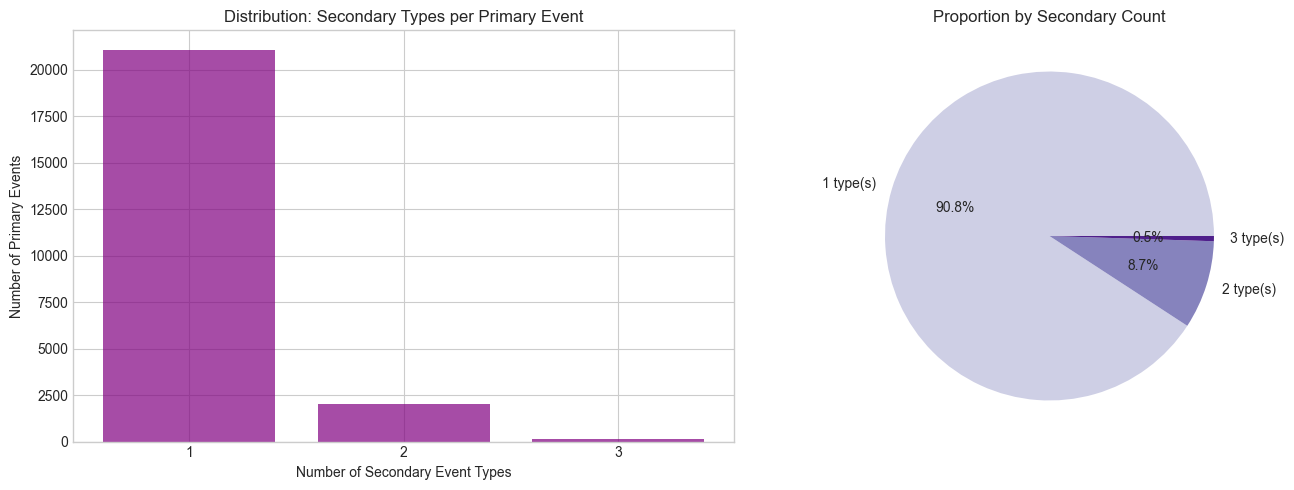


Events triggering cascades: 23,196
Events with 1 secondary type: 21,063
Events with multiple secondaries: 2,133

Examples of multi-secondary events:
            EVENT_TYPE                            target           STATE
520  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA
521  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA
522  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA
547  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA
579  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA
585  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA
624               Hail  [Flash Flood, Thunderstorm Wind]  NORTH CAROLINA
625               Hail  [Flash Flood, Thunderstorm Wind]  NORTH CAROLINA
626               Hail  [Flash Flood, Thunderstorm Wind]  NORTH CAROLINA
676  Thunderstorm Wind               [Flash Flood, Hail]  NORTH CAROLINA


In [229]:
# How Many Events Trigger Multiple Secondaries?

def count_secondaries(target):
    if target is None or (isinstance(target, float) and pd.isna(target)):
        return 0
    
    target_str = str(target).strip()
    
    # Handle empty values
    if target_str in ['', '[]', 'nan', 'None', 'NaN']:
        return 0
    
    # Handle list-like strings: "['Flash Flood', 'Tornado']"
    if target_str.startswith('[') and target_str.endswith(']'):
        # Parse as list
        import ast
        try:
            items = ast.literal_eval(target_str)
            if isinstance(items, list):
                return len([x for x in items if x])  # Count non-empty items
        except:
            pass
    
    # Handle pipe-separated: "Flash Flood|Tornado"
    if '|' in target_str:
        return len([x.strip() for x in target_str.split('|') if x.strip()])
    
    # Single value
    return 1 if target_str else 0

cascade_events = cascade_events.copy()
cascade_events['num_secondaries'] = cascade_events['target'].apply(count_secondaries)

# Distribution - only count events with at least 1 secondary
secondary_counts = cascade_events[cascade_events['num_secondaries'] > 0]['num_secondaries']
secondary_dist = secondary_counts.value_counts().sort_index()

if len(secondary_dist) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart of distribution
    axes[0].bar(secondary_dist.index.astype(str), secondary_dist.values, color='purple', alpha=0.7)
    axes[0].set_xlabel('Number of Secondary Event Types')
    axes[0].set_ylabel('Number of Primary Events')
    axes[0].set_title('Distribution: Secondary Types per Primary Event')

    # Pie chart - only if we have data
    if len(secondary_dist) > 0:
        labels = [f'{int(i)} type(s)' for i in secondary_dist.index]
        colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(secondary_dist)))
        axes[1].pie(secondary_dist.values, labels=labels, autopct='%1.1f%%', colors=colors)
        axes[1].set_title('Proportion by Secondary Count')

    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/multi_secondary_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    multi_secondary = cascade_events[cascade_events['num_secondaries'] > 1]
    print(f"\nEvents triggering cascades: {len(cascade_events[cascade_events['num_secondaries'] > 0]):,}")
    print(f"Events with 1 secondary type: {len(cascade_events[cascade_events['num_secondaries'] == 1]):,}")
    print(f"Events with multiple secondaries: {len(multi_secondary):,}")
    
    if len(multi_secondary) > 0:
        print(f"\nExamples of multi-secondary events:")
        print(multi_secondary[['EVENT_TYPE', 'target', 'STATE']].head(10))
else:
    print("No cascade events with secondary types found.")

/var/folders/md/l911vh8d02j9khvbpjpxvb4r0000gn/T/ipykernel_41905/4252243861.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_secondaries = cascade_events.groupby('EVENT_TYPE').apply(get_unique_secondaries)


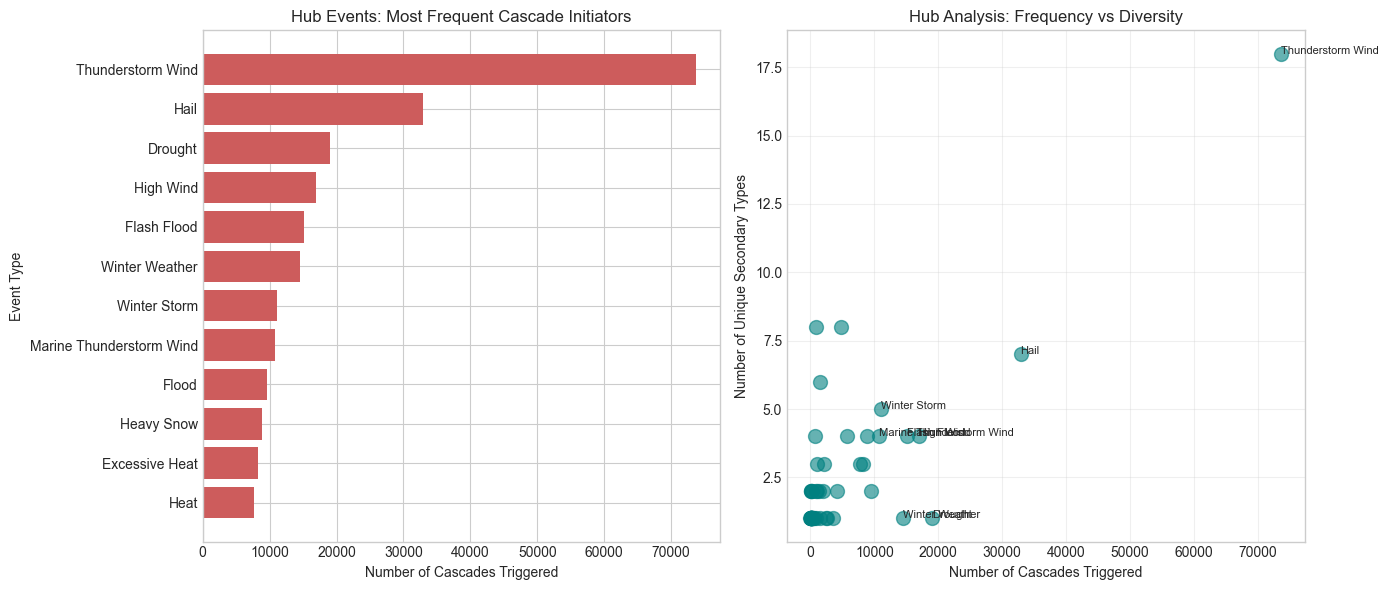


Top 10 Hub Events:
                          Cascade Count  Unique Secondary Types
EVENT_TYPE                                                     
Thunderstorm Wind                 73680                      18
Hail                              32890                       7
Drought                           19015                       1
High Wind                         16951                       4
Flash Flood                       15088                       4
Winter Weather                    14477                       1
Winter Storm                      11039                       5
Marine Thunderstorm Wind          10793                       4
Flood                              9542                       2
Heavy Snow                         8886                       4


In [230]:
# Hub Events: Which event types trigger the most cascades?

# Count how many cascade chains each event type initiates
hub_counts = cascade_events['EVENT_TYPE'].value_counts()

# Also get unique secondary types triggered
def get_unique_secondaries(group):
    all_secondaries = set()
    for target in group['target']:
        if target is not None and not (isinstance(target, float) and pd.isna(target)) and target != '':
            for s in str(target).split('|'):
                all_secondaries.add(s.strip())
    return len(all_secondaries)

unique_secondaries = cascade_events.groupby('EVENT_TYPE').apply(get_unique_secondaries)

# Combine into hub analysis
hub_analysis = pd.DataFrame({
    'Cascade Count': hub_counts,
    'Unique Secondary Types': unique_secondaries
}).sort_values('Cascade Count', ascending=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top hub events by count
top_hubs = hub_analysis.head(12)
axes[0].barh(top_hubs.index[::-1], top_hubs['Cascade Count'][::-1], color='indianred')
axes[0].set_xlabel('Number of Cascades Triggered')
axes[0].set_title('Hub Events: Most Frequent Cascade Initiators')
axes[0].set_ylabel('Event Type')

# Scatter: count vs diversity
axes[1].scatter(hub_analysis['Cascade Count'], hub_analysis['Unique Secondary Types'], 
               s=100, alpha=0.6, c='teal')
for idx, row in hub_analysis.head(8).iterrows():
    axes[1].annotate(idx, (row['Cascade Count'], row['Unique Secondary Types']), 
                    fontsize=8, ha='left')
axes[1].set_xlabel('Number of Cascades Triggered')
axes[1].set_ylabel('Number of Unique Secondary Types')
axes[1].set_title('Hub Analysis: Frequency vs Diversity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/hub_events.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Hub Events:")
print(hub_analysis.head(10))

Multi-step cascade events (A→B→C patterns): 5,925
These events are both triggered BY another event AND trigger subsequent events.



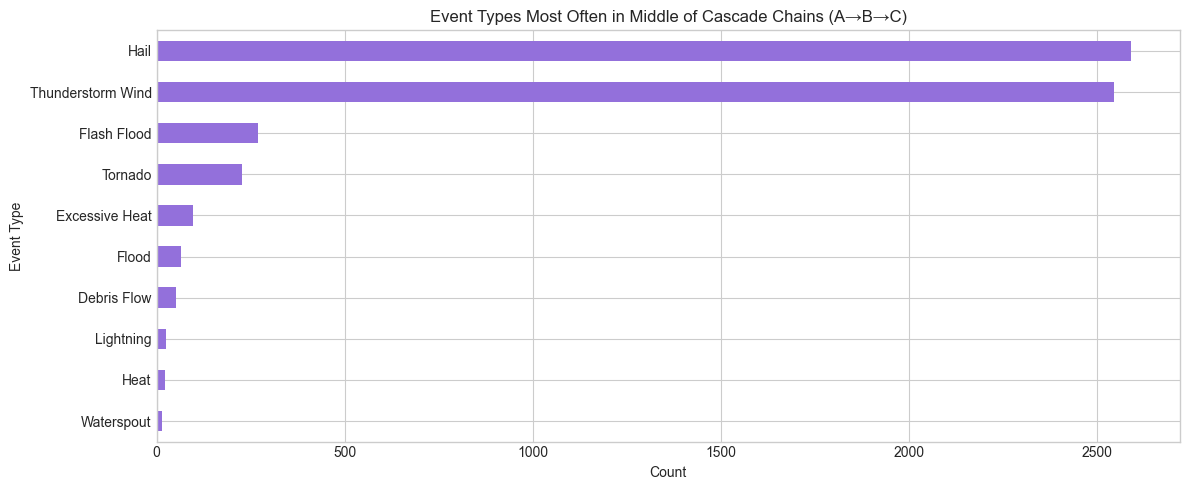


Sample multi-step cascade events:
            EVENT_TYPE               target        STATE  is_cascade_result
54   Thunderstorm Wind               [Hail]     NEBRASKA               True
181        Flash Flood              [Flood]  MISSISSIPPI               True
182        Flash Flood              [Flood]  MISSISSIPPI               True
187               Hail  [Thunderstorm Wind]      GEORGIA               True
201               Hail  [Thunderstorm Wind]      GEORGIA               True
385  Thunderstorm Wind            [Tornado]         OHIO               True
416  Thunderstorm Wind            [Tornado]         OHIO               True
417  Thunderstorm Wind            [Tornado]         OHIO               True
418  Thunderstorm Wind            [Tornado]         OHIO               True
419  Thunderstorm Wind            [Tornado]         OHIO               True


In [231]:
# Multi-step Chains: A→B→C patterns
# An event that is both a cascade result AND triggers another cascade

# Helper to check if target is actually non-empty
def has_valid_target(target):
    if target is None:
        return False
    if isinstance(target, float) and pd.isna(target):
        return False
    target_str = str(target).strip()
    if target_str in ['', '[]', 'nan', 'None']:
        return False
    return True

# Find events that are secondary (cascade results) AND also have valid targets
middle_events = df_labeled[
    (df_labeled['is_cascade_result'] == True) & 
    (df_labeled['target'].apply(has_valid_target))
].copy()

print(f"Multi-step cascade events (A→B→C patterns): {len(middle_events):,}")
print(f"These events are both triggered BY another event AND trigger subsequent events.\n")

if len(middle_events) > 0:
    # What types are most common in the middle?
    middle_types = middle_events['EVENT_TYPE'].value_counts()
    
    plt.figure(figsize=(12, 5))
    if len(middle_types) > 0:
        middle_types.head(10).plot(kind='barh', color='mediumpurple')
        plt.xlabel('Count')
        plt.ylabel('Event Type')
        plt.title('Event Types Most Often in Middle of Cascade Chains (A→B→C)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/multi_step_chains.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print("\nSample multi-step cascade events:")
    print(middle_events[['EVENT_TYPE', 'target', 'STATE', 'is_cascade_result']].head(10).to_string())
else:
    print("No multi-step cascade chains found in current dataset.")
    print("This could indicate that cascades in this dataset are mostly single-step (A→B).")
    
    # Show some stats to understand why
    print(f"\nDataset stats:")
    print(f"  Events that are cascade results: {df_labeled['is_cascade_result'].sum():,}")
    print(f"  Events with valid targets: {df_labeled['target'].apply(has_valid_target).sum():,}")

In [232]:
# Save summary tables to results folder

# 1. Top cascade pairs
top_pairs = pairs_df.groupby(['Primary', 'Secondary']).size().sort_values(ascending=False).head(20)
top_pairs.to_csv(f'{RESULTS_DIR}/top_cascade_pairs.csv')

# 2. Hub analysis
hub_analysis.head(20).to_csv(f'{RESULTS_DIR}/hub_events_analysis.csv')

# 3. State cascade counts
state_counts.to_csv(f'{RESULTS_DIR}/state_cascade_counts.csv')

# 4. Damage by cascade type
damage_by_type.head(20).to_csv(f'{RESULTS_DIR}/damage_by_cascade_type.csv')

print('✓ Summary tables saved to results folder:')
for f in os.listdir(RESULTS_DIR):
    filepath = os.path.join(RESULTS_DIR, f)
    size = os.path.getsize(filepath)
    print(f'  - {f} ({size/1024:.1f} KB)')

✓ Summary tables saved to results folder:
  - seasonal_cascade_patterns.png (155.0 KB)
  - hub_events_analysis.csv (0.4 KB)
  - economic_impact_by_type.png (74.0 KB)
  - hub_events.png (97.2 KB)
  - event_duration_by_type.png (60.6 KB)
  - multi_step_chains.png (42.5 KB)
  - damage_by_cascade_type.csv (1.0 KB)
  - cascade_vs_isolated_damage.png (65.4 KB)
  - regional_cascade_patterns.png (55.7 KB)
  - cascade_network.png (890.7 KB)
  - state_cascade_rates.png (114.7 KB)
  - state_cascade_counts.csv (0.3 KB)
  - multi_secondary_distribution.png (68.5 KB)
  - cooccurrence_heatmap.png (198.0 KB)
  - top_cascade_pairs.csv (0.4 KB)
  - cascade_fatalities.png (56.1 KB)


## Part 10: Save Enhanced Dataset

Saving the labeled dataset with all key columns for prediction.

In [233]:
# Save Enhanced Dataset with All Key Columns
import os

# Define all key columns needed for prediction
key_cols = [
    # Identifiers
    'EVENT_ID', 'EPISODE_ID', 'EVENT_TYPE',
    
    # Location - critical for spatial cascade matching
    'STATE', 'CZ_NAME', 'STATE_FIPS', 'CZ_FIPS', 'CZ_TYPE',
    'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
    'WFO',  # Weather Forecast Office
    
    # Temporal - critical for cascade sequencing
    'BEGIN_DATETIME', 'END_DATETIME',
    
    # Severity metrics
    'MAGNITUDE', 'MAGNITUDE_TYPE',
    'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH',  # Tornado-specific
    'FLOOD_CAUSE',  # Flood-specific
    
    # Impact metrics
    'INJURIES_DIRECT', 'INJURIES_INDIRECT',
    'DEATHS_DIRECT', 'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY_USD', 'DAMAGE_CROPS_USD', 'TOTAL_DAMAGE_USD',
    'FATALITY_COUNT',
    
    # Narrative (for NLP/context)
    'EVENT_NARRATIVE', 'EPISODE_NARRATIVE',
    
    # Data quality
    'SOURCE',
]

# Cascade-specific columns to add
cascade_cols = ['target', 'is_cascade_result']

# Get columns that exist in both df_labeled and the key_cols list
available_key_cols = [c for c in key_cols if c in df_labeled.columns]
missing_cols = [c for c in key_cols if c not in df_labeled.columns]

print(f"Key columns available: {len(available_key_cols)}")
print(f"Key columns missing from df_labeled: {missing_cols}")

# Try to get missing columns from original df
if 'df' in dir():
    # Merge key columns from original df
    cols_to_merge = [c for c in missing_cols if c in df.columns]
    if cols_to_merge and 'EVENT_ID' in df.columns:
        print(f"\nMerging {len(cols_to_merge)} columns from original dataframe...")
        df_enhanced = df_labeled.merge(
            df[['EVENT_ID'] + cols_to_merge].drop_duplicates('EVENT_ID'),
            on='EVENT_ID',
            how='left'
        )
        available_key_cols = [c for c in key_cols if c in df_enhanced.columns]
    else:
        df_enhanced = df_labeled.copy()
else:
    df_enhanced = df_labeled.copy()

# Select final columns
final_cols = available_key_cols + [c for c in cascade_cols if c in df_enhanced.columns]
df_final = df_enhanced[final_cols].copy()

# Save
output_path = '../data/processed/events_labeled_full.csv'
df_final.to_csv(output_path, index=False)

print(f"\n✓ Saved enhanced dataset to: {output_path}")
print(f"  Shape: {df_final.shape}")
print(f"  Columns: {list(df_final.columns)}")
print(f"  File size: {os.path.getsize(output_path) / 1e6:.2f} MB")

Key columns available: 32
Key columns missing from df_labeled: []

✓ Saved enhanced dataset to: ../data/processed/events_labeled_full.csv
  Shape: (268150, 34)
  Columns: ['EVENT_ID', 'EPISODE_ID', 'EVENT_TYPE', 'STATE', 'CZ_NAME', 'STATE_FIPS', 'CZ_FIPS', 'CZ_TYPE', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'WFO', 'BEGIN_DATETIME', 'END_DATETIME', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'FLOOD_CAUSE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY_USD', 'DAMAGE_CROPS_USD', 'TOTAL_DAMAGE_USD', 'FATALITY_COUNT', 'EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'SOURCE', 'target', 'is_cascade_result']
  File size: 230.19 MB
